# Data Analysis for Olfactory Mapping Experiments

## Preliminaries

In [1]:
#@title Import required libraries
import os
import sys

import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

import pandas as pd

import scipy.stats as stats

import seaborn as sns

from IPython.display import display

Adjusting settings and parameters for displaying figures and numbers.

In [2]:
%precision 2
np.set_printoptions(precision=2)
pd.set_option('precision', 2)

SAVE_FORMAT='png'   # 'jpg'
FIG_SAVE_DPI = 300
ALPHA = 0.7
MARKER_SZ = 9
POINT_MARKER = '.'
DEF_LINE_WIDTH = 0.5

# Turn off interactive plotting
plt.ioff()

%matplotlib inline
mpl.rcParams['figure.figsize'] = np.multiply([21, 9], 0.75).tolist()
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = FIG_SAVE_DPI
mpl.rcParams['savefig.pad_inches'] = 0.25
mpl.rcParams['savefig.bbox'] = 'tight'
# mpl.rcParams['scatter.marker'] = POINT_MARKER  # Default='o'
# linestyle DEF: Continuous: '-', Dot: ':', Dash-dot: '-.', Dash: '--'

sns.set_context('notebook')    # paper, talk, poster
sns.set_style('whitegrid')  # darkgrid, whitegrid, dark, white, ticks
# sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

Declare the base directory and data directory variables.

Next, check if the current runtime is 'Local' or 'Hosted'.

If the runtime is hosted, mount Google Drive for data and output, install
cartopy, and change the base directory variable to point to the directory
in Google Drive.

In [3]:
#@title Declare directory variables, etc.
BASE_DIR = '~/work/olfactory-mapping/'
DATA_DIR = 'data/'

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    !apt-get update -qq
    !apt-get install -qq libgdal-dev libproj-dev > /dev/null
    !pip -q install cartopy
    # Suggested by colaboratory
    # !apt-get -qq install python-cartopy python3-cartopy
    !pip -q install MiniSom
    !pip -q install umap-learn

    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/olfactory-mapping/'

## Loading and preprocessing data

In this section, we will load the weather and VoC mixing ratios datasets,
subsequently merging them together as a single dataframe.

The weather data is in a single file, recorded with a one second frequency
from 2018-05-06T13:04:34 until 2018-06-12T10:00:34.

The VoC mixing ratios are in 15 files, recorded with a mean frequency of
20 seconds from 2018-05-06T18:02:24 until 2018-06-12T09:34:47. However, 
the time interval is not equidistant and needs to be adjusted beforehand.

Both datasets contain missing segments.

In [4]:
#@title Create a dictionary for the monitored VoCs based on their mass identifiers to refer to their chemical names.
voc_dict = {'m33': 'Methanol',
            'm42': 'Acetonitrile',
            'm45': 'Acetaldehyde',
            # 'm59': 'Acetone',  # Entire column has missing values
            'm61': 'Acetic acid',
            'm63': 'Dimethyl Sulfide',  # (emitted by algea)
            'm69': 'MBO (Isoprene)',
            'm71': 'MVK (Isoprene, oxygenated)',
            'm73': 'MEK',
            'm79': 'Benzene',
            'm81': 'Pinenes',
            'm93': 'Toluene',
            'm107': 'Xylene',
            # 'm121': 'TMB',  # Over 70% missing values
            'm137': 'a-pinene'
            }

voc_cols = [*voc_dict]
short_lived = [5, 6, 9]
voc_short_lived = [voc_cols[i] for i in short_lived]
voc_long_lived = [voc_cols[i] for i in range(len(voc_cols)) \
                  if i not in short_lived]
del short_lived

Next, we will load the rate coefficients for different *VoC*s 
(in $cm^3\ molecule^{-1}\ s^{-1}$) and define the constant $N_a$ 
(in $molecules\ cm^{-3}$) and the approximate *$OH^-$* mixing 
ratio at sea level.

In [5]:
#@title
rate_coeffs = pd.read_csv(DATA_DIR + 'rate_coeffs.csv', header=0)

# rate_coeffs_pi+limo_nene = pd.read_csv(DATA_DIR +
#                                        'rate_coeffs_[pi,limo]nene.csv',
#                                        header=0)

# CONSTANT N_a
na = 2.55e19

# Approximate OH mixing ratio at sea level (0.15e-6 in ppt)
oh_mixing_ratio = 0.15e-6

# Calculate the lifetimes of different VoCs
lifetimes = 1/(rate_coeffs * oh_mixing_ratio * na)
del na, oh_mixing_ratio, rate_coeffs

Initialize the starting and ending timestamps for the mixing ratios and 
weather dataframes. These timestamps indicate the start and end time for 
the unprocessed datasets.

In [6]:
start_mixing_ratios = pd.Timestamp('2018-05-06 18:02:20', tz='CET')
end_mixing_ratios = pd.Timestamp('2018-06-12 09:34:40', tz='CET')

start_weather_data = pd.Timestamp('2018-05-06 13:04:34', tz='CET')
end_weather_data = pd.Timestamp('2018-06-12 10:00:49', tz='CET')

mean_time = np.timedelta64(20, 's')

Load the mixing ratios datasets and concatenate them together.

In [7]:
mixing_ratios = []

for num in range(15):
    # Load the observed mixing ratios of different *VoC*s (in $ppb$)
    df = pd.read_csv(DATA_DIR + 'VoC_mixing_ratios/mixing_ratios_' + \
                     str(num) + '.csv',  # path
                     header=0,  # Row 0 is header
                     index_col=0,  # Treat Column 0 as index
                     parse_dates=[0],  # Parse Column 0 for dates
                     infer_datetime_format=True,  # Infer format
                     # Ignore columns with large number of missing values
                     usecols=lambda col: col not in ['m59', 'm121'])
    
    # Replace negative (garbage) values with NaN. They will be
    # replaced by interpolated values based on neighboring values
    df[df < 0] = np.NaN
    # Convert *VoC* values from $ppb$ to $ppt$
    df = df.multiply(1000000)
    # Append the current dataframe to the list of mixing ratios dataframes
    mixing_ratios.append(df)
del num, df

# Concatenate all the mixing ratios' dataframes
mixing_ratios = pd.concat(mixing_ratios)

In [8]:
#@title Concatenated mixing ratios dataframe
display(mixing_ratios)

m33        m42       m45        m61        m63  \
DateTime                                                                   
2018-05-06 18:02:24  1.15e+07  134396.99  2.58e+06  391318.01  241864.05   
2018-05-06 18:02:45  1.35e+07  120390.86  2.59e+06  415714.93  341605.88   
2018-05-06 18:03:05  1.08e+07  113552.95  2.36e+06  453781.41  348459.10   
2018-05-06 18:03:25  1.11e+07  125715.53  2.34e+06  339897.49  261769.18   
2018-05-06 18:03:46  1.20e+07  141879.20  2.36e+06  305311.41  338871.79   
...                       ...        ...       ...        ...        ...   
2018-06-12 09:33:21  9.91e+06  104155.31  1.36e+06  137684.35  118331.17   
2018-06-12 09:33:43  9.84e+06   66777.79  1.40e+06  185934.27   98897.05   
2018-06-12 09:34:04  1.04e+07  125757.03  1.32e+06  139167.47        NaN   
2018-06-12 09:34:25  1.22e+07   97000.46  1.40e+06  146415.28  131812.47   
2018-06-12 09:34:47  1.47e+07  125394.44  1.43e+06  172388.77   95100.57   

                           m69        m71        m73        m79        m81  \
DateTime                                                                     
2018-05-06 18:02:24  634641.40   89081.65  320000.54   54742.11  185753.75   
2018-05-06 18:02:45  546458.31  108916.40  142975.29   34511.04  213433.65   
2018-05-06 18:03:05  540979.29  207712.12  151739.19   33936.27  227048.47   
2018-05-06 18:03:25  321895.63  119564.97  344362.05   72229.99  165695.84   
2018-05-06 18:03:46  578053.78   63925.80  168642.26   52879.56  149016.64   
...                        ...        ...        ...        ...        ...   
2018-06-12 09:33:21  385648.07   99397.57  572164.94   46291.13  276014.78   
2018-06-12 09:33:43  340646.05  108721.56  300621.11   55344.31  417762.03   
2018-06-12 09:34:04  376679.32  107702.49  284772.56   84234.49  189643.81   
2018-06-12 09:34:25  453742.05  216235.65  338700.72  134020.24  191071.84   
2018-06-12 09:34:47  411989.79  160800.59  777293.76  103377.41  318880.79   

                           m93       m107       m137  
DateTime                                              
2018-05-06 18:02:24   73853.76        NaN  189497.37  
2018-05-06 18:02:45   49083.27        NaN        NaN  
2018-05-06 18:03:05  104955.09        NaN        NaN  
2018-05-06 18:03:25   37501.52        NaN  328452.29  
2018-05-06 18:03:46   48397.91        NaN  184020.74  
...                        ...        ...        ...  
2018-06-12 09:33:21  205931.94        NaN  192532.09  
2018-06-12 09:33:43  237226.74   94084.84  189495.41  
2018-06-12 09:34:04  294125.80   81208.03  188666.79  
2018-06-12 09:34:25  179705.26   69355.82  335439.38  
2018-06-12 09:34:47  246974.60  165929.63        NaN  

[137030 rows x 13 columns]

In [9]:
#@title Mixing ratios dataframe summary statistics
mixing_ratios.describe()

m33       m42       m45       m61        m63       m69       m71  \
count  1.36e+05  1.28e+05  1.37e+05  9.65e+04   90468.00  5.94e+04  6.26e+04   
mean   9.05e+06  9.85e+04  1.46e+06  2.28e+05  132620.17  5.32e+05  1.10e+05   
std    5.41e+06  3.90e+04  3.77e+05  1.63e+05   60013.01  3.41e+05  9.76e+04   
min    1.89e+06  3.19e+04  6.49e+05  7.73e+04   65800.62  2.31e+05  3.08e+00   
25%    5.80e+06  7.04e+04  1.23e+06  1.24e+05   87845.98  3.16e+05  5.24e+04   
50%    7.96e+06  9.39e+04  1.43e+06  1.77e+05  115256.35  4.19e+05  8.24e+04   
75%    1.09e+07  1.20e+05  1.64e+06  2.75e+05  159861.43  6.26e+05  1.32e+05   
max    1.34e+08  1.10e+06  2.25e+07  5.15e+06  575437.38  1.01e+07  2.89e+06   

            m73       m79       m81       m93      m107      m137  
count  1.12e+05  1.01e+05  1.12e+05  9.98e+04  6.41e+04  7.87e+04  
mean   3.09e+05  1.17e+05  8.79e+05  1.98e+05  1.81e+05  8.40e+05  
std    2.29e+05  7.25e+04  8.79e+05  2.50e+05  1.07e+05  6.53e+05  
min    9.28e+04  4.08e+01  6.74e+04  3.50e+00  6.05e+04  1.44e+05  
25%    1.71e+05  6.23e+04  1.56e+05  6.43e+04  9.91e+04  3.57e+05  
50%    2.45e+05  1.03e+05  6.50e+05  1.41e+05  1.55e+05  6.73e+05  
75%    3.71e+05  1.57e+05  1.29e+06  2.74e+05  2.36e+05  1.13e+06  
max    1.09e+07  4.05e+06  9.59e+06  5.62e+06  4.02e+06  7.17e+06

In [10]:
#@title Mean and median time interval between observations of mixing ratios dataframe
temp = mixing_ratios.index.to_series().diff()
print('Mean interval:', temp.mean())
print('Median interval: ', temp.median())

Mean interval: 0 days 00:00:23.107101
Median interval:  0 days 00:00:21


Since the time interval between mixing ratio readings is not consistent, 
we can process the data such that the time is:
*   *Floor*ed
*   *Ceil*ed
*   *Round*ed

to 20 second multiples. However, all three strategies have certain 
problems associated with them because of drifting interval between 
readings, e.g. rounding causes duplicated indices.

Therefore, we will resample over a 20 second interval 
and use the average values to retain the most amount of usable data. This 
also inserts any missing segments according to the required frequency.

In [11]:
mixing_ratios = mixing_ratios.resample('20S').mean()

mixing_ratios.index = mixing_ratios.index.tz_localize('CET')

In [12]:
#@title Mixing ratios dataframe after resampling
display(mixing_ratios)

m33        m42       m45        m61  \
DateTime                                                              
2018-05-06 18:02:20+02:00  1.15e+07  134396.99  2.58e+06  391318.01   
2018-05-06 18:02:40+02:00  1.35e+07  120390.86  2.59e+06  415714.93   
2018-05-06 18:03:00+02:00  1.08e+07  113552.95  2.36e+06  453781.41   
2018-05-06 18:03:20+02:00  1.11e+07  125715.53  2.34e+06  339897.49   
2018-05-06 18:03:40+02:00  1.20e+07  141879.20  2.36e+06  305311.41   
...                             ...        ...       ...        ...   
2018-06-12 09:33:20+02:00  9.91e+06  104155.31  1.36e+06  137684.35   
2018-06-12 09:33:40+02:00  9.84e+06   66777.79  1.40e+06  185934.27   
2018-06-12 09:34:00+02:00  1.04e+07  125757.03  1.32e+06  139167.47   
2018-06-12 09:34:20+02:00  1.22e+07   97000.46  1.40e+06  146415.28   
2018-06-12 09:34:40+02:00  1.47e+07  125394.44  1.43e+06  172388.77   

                                 m63        m69        m71        m73  \
DateTime                                                                
2018-05-06 18:02:20+02:00  241864.05  634641.40   89081.65  320000.54   
2018-05-06 18:02:40+02:00  341605.88  546458.31  108916.40  142975.29   
2018-05-06 18:03:00+02:00  348459.10  540979.29  207712.12  151739.19   
2018-05-06 18:03:20+02:00  261769.18  321895.63  119564.97  344362.05   
2018-05-06 18:03:40+02:00  338871.79  578053.78   63925.80  168642.26   
...                              ...        ...        ...        ...   
2018-06-12 09:33:20+02:00  118331.17  385648.07   99397.57  572164.94   
2018-06-12 09:33:40+02:00   98897.05  340646.05  108721.56  300621.11   
2018-06-12 09:34:00+02:00        NaN  376679.32  107702.49  284772.56   
2018-06-12 09:34:20+02:00  131812.47  453742.05  216235.65  338700.72   
2018-06-12 09:34:40+02:00   95100.57  411989.79  160800.59  777293.76   

                                 m79        m81        m93       m107  \
DateTime                                                                
2018-05-06 18:02:20+02:00   54742.11  185753.75   73853.76        NaN   
2018-05-06 18:02:40+02:00   34511.04  213433.65   49083.27        NaN   
2018-05-06 18:03:00+02:00   33936.27  227048.47  104955.09        NaN   
2018-05-06 18:03:20+02:00   72229.99  165695.84   37501.52        NaN   
2018-05-06 18:03:40+02:00   52879.56  149016.64   48397.91        NaN   
...                              ...        ...        ...        ...   
2018-06-12 09:33:20+02:00   46291.13  276014.78  205931.94        NaN   
2018-06-12 09:33:40+02:00   55344.31  417762.03  237226.74   94084.84   
2018-06-12 09:34:00+02:00   84234.49  189643.81  294125.80   81208.03   
2018-06-12 09:34:20+02:00  134020.24  191071.84  179705.26   69355.82   
2018-06-12 09:34:40+02:00  103377.41  318880.79  246974.60  165929.63   

                                m137  
DateTime                              
2018-05-06 18:02:20+02:00  189497.37  
2018-05-06 18:02:40+02:00        NaN  
2018-05-06 18:03:00+02:00        NaN  
2018-05-06 18:03:20+02:00  328452.29  
2018-05-06 18:03:40+02:00  184020.74  
...                              ...  
2018-06-12 09:33:20+02:00  192532.09  
2018-06-12 09:33:40+02:00  189495.41  
2018-06-12 09:34:00+02:00  188666.79  
2018-06-12 09:34:20+02:00  335439.38  
2018-06-12 09:34:40+02:00        NaN  

[158318 rows x 13 columns]

In [13]:
#@title Mixing ratios dataframe summary statistics after resampling
mixing_ratios.describe()

m33       m42       m45       m61        m63       m69       m71  \
count  1.36e+05  1.28e+05  1.37e+05  9.65e+04   90468.00  5.94e+04  6.26e+04   
mean   9.05e+06  9.85e+04  1.46e+06  2.28e+05  132620.17  5.32e+05  1.10e+05   
std    5.41e+06  3.90e+04  3.77e+05  1.63e+05   60013.01  3.41e+05  9.76e+04   
min    1.89e+06  3.19e+04  6.49e+05  7.73e+04   65800.62  2.31e+05  3.08e+00   
25%    5.80e+06  7.04e+04  1.23e+06  1.24e+05   87845.98  3.16e+05  5.24e+04   
50%    7.96e+06  9.39e+04  1.43e+06  1.77e+05  115256.35  4.19e+05  8.24e+04   
75%    1.09e+07  1.20e+05  1.64e+06  2.75e+05  159861.43  6.26e+05  1.32e+05   
max    1.34e+08  1.10e+06  2.25e+07  5.15e+06  575437.38  1.01e+07  2.89e+06   

            m73       m79       m81       m93      m107      m137  
count  1.12e+05  1.01e+05  1.12e+05  9.98e+04  6.41e+04  7.87e+04  
mean   3.09e+05  1.17e+05  8.79e+05  1.98e+05  1.81e+05  8.40e+05  
std    2.29e+05  7.25e+04  8.79e+05  2.50e+05  1.07e+05  6.53e+05  
min    9.28e+04  4.08e+01  6.74e+04  3.50e+00  6.05e+04  1.44e+05  
25%    1.71e+05  6.23e+04  1.56e+05  6.43e+04  9.91e+04  3.57e+05  
50%    2.45e+05  1.03e+05  6.50e+05  1.41e+05  1.55e+05  6.73e+05  
75%    3.71e+05  1.57e+05  1.29e+06  2.74e+05  2.36e+05  1.13e+06  
max    1.09e+07  4.05e+06  9.59e+06  5.62e+06  4.02e+06  7.17e+06

Next, we will load the weather data and resample with one second 
frequency to include the missing segments.

After resampling, we truncate the weather data to remove the segments 
which are irrelevant because of unavailable mixing ratios data.

In [14]:
# Load the weather conditions data
weather_data = pd.read_csv(DATA_DIR + 'weather/weather_data.csv',  # path
                           header=0,  # Row 0 is header
                           index_col=0,  # Treat Column 0 as index
                           parse_dates=[0],  # Parse Column 0 for dates
                           infer_datetime_format=True,  # Infer format
                           )

weather_cols = weather_data.columns.to_list()

In [15]:
#@title Weather conditions dataframe
display(weather_data)

Wind Direction  Wind Speed  Temperature  Humidity  \
DateTime                                                                 
2018-05-06 13:04:34           299.0         1.9         18.8      82.4   
2018-05-06 13:04:35           299.0         1.9         18.8      82.3   
2018-05-06 13:04:36           299.0         1.9         18.8      82.3   
2018-05-06 13:04:37           299.0         1.9         18.8      82.0   
2018-05-06 13:04:38           299.0         1.9         18.8      81.6   
...                             ...         ...          ...       ...   
2018-06-12 10:00:45           251.0         0.3         22.9      76.0   
2018-06-12 10:00:46           251.0         0.3         22.9      76.0   
2018-06-12 10:00:47           251.0         0.3         23.0      76.1   
2018-06-12 10:00:48           251.0         0.3         22.9      76.1   
2018-06-12 10:00:49           251.0         0.3         22.9      76.1   

                     Pressure  Precipitation  
DateTime                                      
2018-05-06 13:04:34    1015.7            0.0  
2018-05-06 13:04:35    1015.7            0.0  
2018-05-06 13:04:36    1015.7            0.0  
2018-05-06 13:04:37    1015.7            0.0  
2018-05-06 13:04:38    1015.7            0.0  
...                       ...            ...  
2018-06-12 10:00:45    1008.9            0.0  
2018-06-12 10:00:46    1008.9            0.0  
2018-06-12 10:00:47    1008.9            0.0  
2018-06-12 10:00:48    1008.9            0.0  
2018-06-12 10:00:49    1008.9            0.0  

[3185586 rows x 6 columns]

In [16]:
#@title Weahter data summary statistics
weather_data.describe()

Wind Direction  Wind Speed  Temperature  Humidity  Pressure  \
count        3.11e+06    3.11e+06     3.11e+06  3.11e+06  3.11e+06   
mean         2.07e+02    1.64e+00     1.87e+01  7.82e+01  1.01e+03   
std          1.05e+02    1.22e+00     3.59e+00  1.10e+01  2.98e+00   
min          0.00e+00    0.00e+00     9.00e+00  3.07e+01  1.01e+03   
25%          1.14e+02    6.00e-01     1.63e+01  7.05e+01  1.01e+03   
50%          2.28e+02    1.40e+00     1.90e+01  7.95e+01  1.01e+03   
75%          3.03e+02    2.40e+00     2.12e+01  8.79e+01  1.02e+03   
max          3.60e+02    9.20e+00     2.76e+01  9.37e+01  1.02e+03   

       Precipitation  
count       3.11e+06  
mean        9.97e-02  
std         1.53e+00  
min         0.00e+00  
25%         0.00e+00  
50%         0.00e+00  
75%         0.00e+00  
max         1.82e+02

In [17]:
#@title Mean and median interval between observations of weather dataframe
temp = weather_data.index.to_series().diff()
print('Mean interval:', temp.mean())
print('Median interval: ', temp.median())

Mean interval: 0 days 00:00:01.000059
Median interval:  0 days 00:00:01


The weather data will also be resampled at a 1 second interval to account 
for missing observations, etc.

Next, the weather data is truncated to have the same range as the mixing 
ratios dataframe.

In [18]:
weather_data = weather_data.resample('1S').mean()

weather_data.index = weather_data.index.tz_localize('CET')

# Truncate the data for times where the mixing ratios data is unavailable
weather_data = weather_data.truncate(before=start_mixing_ratios-mean_time,
                                     after=end_mixing_ratios)

In [19]:
#@title Resampled and truncated weather data
display(weather_data)

Wind Direction  Wind Speed  Temperature  Humidity  \
DateTime                                                                       
2018-05-06 18:02:00+02:00           273.0         0.5         19.1      75.9   
2018-05-06 18:02:01+02:00           285.0         0.7         19.1      75.9   
2018-05-06 18:02:02+02:00           285.0         0.7         19.1      75.9   
2018-05-06 18:02:03+02:00           285.0         0.7         19.1      75.9   
2018-05-06 18:02:04+02:00           285.0         0.7         19.1      75.9   
...                                   ...         ...          ...       ...   
2018-06-12 09:34:36+02:00           202.0         1.8         23.2      69.8   
2018-06-12 09:34:37+02:00           202.0         1.8         23.2      69.7   
2018-06-12 09:34:38+02:00           210.0         1.8         23.2      69.7   
2018-06-12 09:34:39+02:00           210.0         1.8         23.2      69.8   
2018-06-12 09:34:40+02:00           210.0         1.8         23.2      69.8   

                           Pressure  Precipitation  
DateTime                                            
2018-05-06 18:02:00+02:00    1014.7            0.0  
2018-05-06 18:02:01+02:00    1014.7            0.0  
2018-05-06 18:02:02+02:00    1014.7            0.0  
2018-05-06 18:02:03+02:00    1014.7            0.0  
2018-05-06 18:02:04+02:00    1014.7            0.0  
...                             ...            ...  
2018-06-12 09:34:36+02:00    1009.0            0.0  
2018-06-12 09:34:37+02:00    1009.0            0.0  
2018-06-12 09:34:38+02:00    1009.0            0.0  
2018-06-12 09:34:39+02:00    1009.0            0.0  
2018-06-12 09:34:40+02:00    1009.0            0.0  

[3166361 rows x 6 columns]

In [20]:
#@title Resampled and truncated weather data summary statistics
weather_data.describe()

Wind Direction  Wind Speed  Temperature  Humidity  Pressure  \
count        3.10e+06    3.10e+06     3.10e+06  3.10e+06  3.10e+06   
mean         2.07e+02    1.64e+00     1.87e+01  7.82e+01  1.01e+03   
std          1.05e+02    1.22e+00     3.60e+00  1.10e+01  2.98e+00   
min          0.00e+00    0.00e+00     9.00e+00  3.07e+01  1.01e+03   
25%          1.13e+02    6.00e-01     1.63e+01  7.05e+01  1.01e+03   
50%          2.27e+02    1.30e+00     1.90e+01  7.95e+01  1.01e+03   
75%          3.03e+02    2.40e+00     2.12e+01  8.79e+01  1.02e+03   
max          3.60e+02    9.20e+00     2.76e+01  9.37e+01  1.02e+03   

       Precipitation  
count       3.10e+06  
mean        1.00e-01  
std         1.53e+00  
min         0.00e+00  
25%         0.00e+00  
50%         0.00e+00  
75%         0.00e+00  
max         1.82e+02

In [21]:
#@title Weather data units of measurements
weather_units = {'Wind Direction': 'degrees',
                 'Wind Speed': 'meters per second',
                 'Temperature': 'celsius',
                 'Humidity': 'percentage',
                 'Pressure': 'hPa',
                 'Precipitation': 'mm'}

Now that the mixing ratios and weather datasets have been loaded and 
cleaned/preprocessed, we will merge the two together.

The merging strategy for merging the two datasets can be either of the 
following:

*   Use average weather conditions since last mixing ratio reading
    * Set flag to **True**
*   Use instantaneous weather conditions
    * Set flag to **False**

In [22]:
using_avg_weather_conditions = False

if using_avg_weather_conditions:
    print('Using average conditions')
    merged_df = pd.DataFrame(mixing_ratios, copy=True)

    indices_df = pd.concat([weather_data.index.to_series(),
                            mixing_ratios.index.to_series()], axis=1)
    indices_df.columns = ['weather', 'ratios']
    temp = (indices_df['weather'] == indices_df['ratios'])
    temp = temp.shift().cumsum().dropna()
    for col in weather_data.columns:
        merged_df[col] = weather_data.groupby(temp)[col].mean().values
    del temp, indices_df
else:
    print('Using instantaneous conditions')
    merged_df = pd.concat([mixing_ratios, weather_data], axis=1,
                          join='inner')
    merged_df.index.name = 'DateTime'

Using instantaneous conditions


In [23]:
#@title Merged dataframe
display(merged_df)

m33        m42       m45        m61  \
DateTime                                                              
2018-05-06 18:02:20+02:00  1.15e+07  134396.99  2.58e+06  391318.01   
2018-05-06 18:02:40+02:00  1.35e+07  120390.86  2.59e+06  415714.93   
2018-05-06 18:03:00+02:00  1.08e+07  113552.95  2.36e+06  453781.41   
2018-05-06 18:03:20+02:00  1.11e+07  125715.53  2.34e+06  339897.49   
2018-05-06 18:03:40+02:00  1.20e+07  141879.20  2.36e+06  305311.41   
...                             ...        ...       ...        ...   
2018-06-12 09:33:20+02:00  9.91e+06  104155.31  1.36e+06  137684.35   
2018-06-12 09:33:40+02:00  9.84e+06   66777.79  1.40e+06  185934.27   
2018-06-12 09:34:00+02:00  1.04e+07  125757.03  1.32e+06  139167.47   
2018-06-12 09:34:20+02:00  1.22e+07   97000.46  1.40e+06  146415.28   
2018-06-12 09:34:40+02:00  1.47e+07  125394.44  1.43e+06  172388.77   

                                 m63        m69        m71        m73  \
DateTime                                                                
2018-05-06 18:02:20+02:00  241864.05  634641.40   89081.65  320000.54   
2018-05-06 18:02:40+02:00  341605.88  546458.31  108916.40  142975.29   
2018-05-06 18:03:00+02:00  348459.10  540979.29  207712.12  151739.19   
2018-05-06 18:03:20+02:00  261769.18  321895.63  119564.97  344362.05   
2018-05-06 18:03:40+02:00  338871.79  578053.78   63925.80  168642.26   
...                              ...        ...        ...        ...   
2018-06-12 09:33:20+02:00  118331.17  385648.07   99397.57  572164.94   
2018-06-12 09:33:40+02:00   98897.05  340646.05  108721.56  300621.11   
2018-06-12 09:34:00+02:00        NaN  376679.32  107702.49  284772.56   
2018-06-12 09:34:20+02:00  131812.47  453742.05  216235.65  338700.72   
2018-06-12 09:34:40+02:00   95100.57  411989.79  160800.59  777293.76   

                                 m79        m81        m93       m107  \
DateTime                                                                
2018-05-06 18:02:20+02:00   54742.11  185753.75   73853.76        NaN   
2018-05-06 18:02:40+02:00   34511.04  213433.65   49083.27        NaN   
2018-05-06 18:03:00+02:00   33936.27  227048.47  104955.09        NaN   
2018-05-06 18:03:20+02:00   72229.99  165695.84   37501.52        NaN   
2018-05-06 18:03:40+02:00   52879.56  149016.64   48397.91        NaN   
...                              ...        ...        ...        ...   
2018-06-12 09:33:20+02:00   46291.13  276014.78  205931.94        NaN   
2018-06-12 09:33:40+02:00   55344.31  417762.03  237226.74   94084.84   
2018-06-12 09:34:00+02:00   84234.49  189643.81  294125.80   81208.03   
2018-06-12 09:34:20+02:00  134020.24  191071.84  179705.26   69355.82   
2018-06-12 09:34:40+02:00  103377.41  318880.79  246974.60  165929.63   

                                m137  Wind Direction  Wind Speed  Temperature  \
DateTime                                                                        
2018-05-06 18:02:20+02:00  189497.37           285.0         0.7         19.1   
2018-05-06 18:02:40+02:00        NaN           272.0         0.7         19.1   
2018-05-06 18:03:00+02:00        NaN           272.0         0.7         19.1   
2018-05-06 18:03:20+02:00  328452.29           296.0         2.3         19.1   
2018-05-06 18:03:40+02:00  184020.74           289.0         2.3         19.1   
...                              ...             ...         ...          ...   
2018-06-12 09:33:20+02:00  192532.09           158.0         1.1         23.1   
2018-06-12 09:33:40+02:00  189495.41           204.0         1.3         23.1   
2018-06-12 09:34:00+02:00  188666.79           204.0         1.3         23.2   
2018-06-12 09:34:20+02:00  335439.38           202.0         1.8         23.2   
2018-06-12 09:34:40+02:00        NaN           210.0         1.8         23.2   

                           Humidity  Pressure  Precipitation  
DateTime                                                      
2018-05-06 18:02:20+02:00   

In [24]:
#@title Merged dataframe summary statistics
merged_df.describe()

m33       m42       m45       m61        m63       m69       m71  \
count  1.36e+05  1.28e+05  1.37e+05  9.65e+04   90468.00  5.94e+04  6.26e+04   
mean   9.05e+06  9.85e+04  1.46e+06  2.28e+05  132620.17  5.32e+05  1.10e+05   
std    5.41e+06  3.90e+04  3.77e+05  1.63e+05   60013.01  3.41e+05  9.76e+04   
min    1.89e+06  3.19e+04  6.49e+05  7.73e+04   65800.62  2.31e+05  3.08e+00   
25%    5.80e+06  7.04e+04  1.23e+06  1.24e+05   87845.98  3.16e+05  5.24e+04   
50%    7.96e+06  9.39e+04  1.43e+06  1.77e+05  115256.35  4.19e+05  8.24e+04   
75%    1.09e+07  1.20e+05  1.64e+06  2.75e+05  159861.43  6.26e+05  1.32e+05   
max    1.34e+08  1.10e+06  2.25e+07  5.15e+06  575437.38  1.01e+07  2.89e+06   

            m73       m79       m81       m93      m107      m137  \
count  1.12e+05  1.01e+05  1.12e+05  9.98e+04  6.41e+04  7.87e+04   
mean   3.09e+05  1.17e+05  8.79e+05  1.98e+05  1.81e+05  8.40e+05   
std    2.29e+05  7.25e+04  8.79e+05  2.50e+05  1.07e+05  6.53e+05   
min    9.28e+04  4.08e+01  6.74e+04  3.50e+00  6.05e+04  1.44e+05   
25%    1.71e+05  6.23e+04  1.56e+05  6.43e+04  9.91e+04  3.57e+05   
50%    2.45e+05  1.03e+05  6.50e+05  1.41e+05  1.55e+05  6.73e+05   
75%    3.71e+05  1.57e+05  1.29e+06  2.74e+05  2.36e+05  1.13e+06   
max    1.09e+07  4.05e+06  9.59e+06  5.62e+06  4.02e+06  7.17e+06   

       Wind Direction  Wind Speed  Temperature   Humidity   Pressure  \
count       154926.00   154926.00    154926.00  154926.00  154926.00   
mean           206.94        1.64        18.73      78.16    1014.04   
std            104.74        1.22         3.60      11.03       2.98   
min              0.00        0.00         9.00      30.70    1005.60   
25%            113.00        0.60        16.30      70.50    1012.00   
50%            227.00        1.30        19.00      79.50    1014.40   
75%            303.00        2.40        21.20      87.90    1016.40   
max            359.00        9.20        27.60      93.70    1019.90   

       Precipitation  
count      154926.00  
mean            0.10  
std             1.53  
min             0.00  
25%             0.00  
50%             0.00  
75%             0.00  
max           180.30

In [25]:
#@title Percentage of missing data per column
100*merged_df.isna().sum()/len(merged_df.index)

m33               13.80
m42               18.91
m45               13.45
m61               39.03
m63               42.86
m69               62.46
m71               60.47
m73               29.27
m79               36.32
m81               29.05
m93               36.95
m107              59.50
m137              50.28
Wind Direction     2.14
Wind Speed         2.14
Temperature        2.14
Humidity           2.14
Pressure           2.14
Precipitation      2.14
dtype: float64

If desired, the missing values can be filled using interpolation/filling.

In [26]:
imputation_desired = False

In [27]:
#@title
if imputation_desired:
    # Impute missing values using index frequency
    merged_df.interpolate(method='index', inplace=True)
    # then use forward filling for entries at the end
    merged_df.fillna(method='ffill', inplace=True)
    # and finally use back filling for entries at the start
    merged_df.fillna(method='backfill', inplace=True)

The wind direction (in degrees) is recorded as integer, however, for 
preprocessing and interpolation, it was treated as a floating point 
number. In the next cell, the wind direction is converted back to integer.

In [28]:
#@title
if imputation_desired:
    merged_df['Wind Direction'] = merged_df['Wind Direction'].astype('int')

The data can be grouped based on weekly basis. For this, the first day of
observations (2018-05-06: Sunday) upto the next Saturday are considered as
week 0, and so on until the last day of observations (2018-06-12).

In [29]:
#@title Add week number for grouping data

# Get the difference between observation time and
# observation start time normalized to midnight
temp = merged_df.index.to_series() - start_mixing_ratios.normalize()
# Divide the difference by a '7 day' time delta to get fractions of weeks
temp = temp / pd.Timedelta('7days')
# Floor the results to get whole week numbers
s = np.floor(temp)

merged_df.insert(column='Week Number', loc=0, value=s.astype(int))

In [30]:
#@title Merged dataframe sample after addition of week number
merged_df.sample(18).sort_index()

Week Number       m33        m42       m45  \
DateTime                                                                
2018-05-06 19:10:20+02:00            0  1.18e+07  163679.75  2.01e+06   
2018-05-08 09:48:20+02:00            0  8.39e+06   85995.07  1.75e+06   
2018-05-12 09:39:20+02:00            0       NaN        NaN       NaN   
2018-05-13 16:35:00+02:00            1  6.16e+06  112724.01  1.29e+06   
2018-05-16 20:48:20+02:00            1  8.45e+06   44143.99  1.90e+06   
2018-05-19 10:26:00+02:00            1  1.39e+07  184527.68  2.05e+06   
2018-05-19 15:55:00+02:00            1  1.22e+07  116988.05  1.35e+06   
2018-05-21 18:58:00+02:00            2  1.20e+07  165944.14  1.37e+06   
2018-05-25 12:56:00+02:00            2  1.31e+07  122054.26  1.74e+06   
2018-05-28 11:22:00+02:00            3       NaN        NaN       NaN   
2018-05-29 15:46:40+02:00            3       NaN        NaN       NaN   
2018-05-30 06:50:00+02:00            3       NaN        NaN       NaN   
2018-06-05 07:35:00+02:00            4  5.37e+06  113719.86  1.29e+06   
2018-06-05 08:50:20+02:00            4  9.58e+06  128677.47  1.05e+06   
2018-06-06 17:26:00+02:00            4  6.17e+06   70524.76  1.42e+06   
2018-06-10 02:05:40+02:00            5  9.01e+06        NaN  1.30e+06   
2018-06-10 02:22:00+02:00            5  4.60e+06        NaN  1.33e+06   
2018-06-11 06:32:20+02:00            5  8.05e+06  153232.71  1.66e+06   

                                 m61        m63        m69        m71  \
DateTime                                                                
2018-05-06 19:10:20+02:00  341549.39  292345.77  378633.31   83986.47   
2018-05-08 09:48:20+02:00  232211.58  113102.53        NaN   67588.22   
2018-05-12 09:39:20+02:00        NaN        NaN        NaN        NaN   
2018-05-13 16:35:00+02:00  216137.45  188144.04        NaN        NaN   
2018-05-16 20:48:20+02:00   78185.12   79082.19        NaN   87531.54   
2018-05-19 10:26:00+02:00  455554.26   95124.95  722050.53  160661.47   
2018-05-19 15:55:00+02:00  247259.62  131447.88        NaN        NaN   
2018-05-21 18:58:00+02:00  113854.45        NaN  370376.95  113304.89   
2018-05-25 12:56:00+02:00  374111.98        NaN        NaN        NaN   
2018-05-28 11:22:00+02:00        NaN        NaN        NaN        NaN   
2018-05-29 15:46:40+02:00        NaN        NaN        NaN        NaN   
2018-05-30 06:50:00+02:00        NaN        NaN        NaN        NaN   
2018-06-05 07:35:00+02:00   79920.35        NaN  680306.54        NaN   
2018-06-05 08:50:20+02:00        NaN        NaN        NaN   59755.97   
2018-06-06 17:26:00+02:00  144893.56        NaN  658798.45        NaN   
2018-06-10 02:05:40+02:00        NaN        NaN        NaN        NaN   
2018-06-10 02:22:00+02:00        NaN        NaN        NaN        NaN   
2018-06-11 06:32:20+02:00  762192.81        NaN        NaN   94168.48   

                                 m73        m79       m81        m93  \
DateTime                                                               
2018-05-06 19:10:20+02:00  232872.30   46397.04  2.61e+05   30051.74   
2018-05-08 09:48:20+02:00  258154.43  108038.21  1.92e+05  152274.29   
2018-05-12 09:39:20+02:00        NaN        NaN       NaN        NaN   
2018-05-13 16:35:00+02:00  230286.28   57213.12  1.48e+05        NaN   
2018-05-16 20:48:20+02:00  645039.23  111533.40  2.00e+06  122700.60   
2018-05-19 10:26:00+02:00  341042.80  140218.55  4.77e+05  437781.18   
2018-05-19 15:55:00+02:00  267974.51        NaN  9.88e+04    7638.48   
2018-05-21 18:58:00+02:00  239977.20   62190.69  3.13e+05   69741.24   
2018-05-25 12:56:00+02:00  345014.29  133350.11       NaN  153488.23   
2018-05-28 11:22:00+02:00        NaN        NaN       NaN        NaN   
2018-05-29 15:46:40+02:00        NaN        NaN       NaN        NaN   
2018-05-30 06:50:00+02:00        NaN        NaN       NaN        NaN   
2018-06-05 07:35:00+02:00  245021.64  127763.71  6.01e+05  225990.38   
2018-06-05 08:50:20+02:00

Now, we will add the instantaneous distance travelled by the *VoC*s 
during the *VoC* measurement time.

In [31]:
#@title Add instatneous distance travelled by VoCs during one observation interval
temp = merged_df.index.to_series().diff()
temp.iloc[0] = mean_time
temp = temp.astype('timedelta64[s]')

merged_df.insert(column='Instantaneous Distance',
                 loc=len(merged_df.columns),
                 value=merged_df['Wind Speed']*temp)

The latitude and longitude of the aviary are defined below.

In [32]:
AVIARY_LAT = 43.656895      # 43 deg 39 min 24.822 sec N
AVIARY_LON = 10.304030      # 10 deg 18 min 14.508 sec E

## Feature generation

Next, we will add a column to the merged data to identify day or night time
based on the solar azimuth.

In [33]:
import skyfield.api
import skyfield.almanac

ts = skyfield.api.load.timescale()
planets = skyfield.api.load('de421.bsp')

aviary = skyfield.api.Topos(latitude_degrees=AVIARY_LAT,
                            longitude_degrees=AVIARY_LON)

is_day_or_night = skyfield.almanac.sunrise_sunset(planets, aviary)

day_or_night = is_day_or_night(ts.utc(merged_df.index.to_pydatetime()))

s = pd.Series(data=['Day' if is_day else 'Night' for is_day in day_or_night],
              index = merged_df.index, dtype='category')

merged_df['Day or Night'] = s

Next, we add a column to the merged dataframe to identify the different 
phases of the day, i.e., morning/noon/evening. This distinction is made 
using the zenith angle. For morning, after sunrise, the zenith angle is 
90 degrees and decreases as the sun rises. The morning phase is considered
until the zenith angle is above 45-50 degrees. After this point the noon 
phase starts, which ends when the zenith angle falls below 45-50 degrees 
as the sun starts moving towards the west horizon and the evening phase 
starts. The night phase is already calculated above, which is then added.

In [34]:
earth, sun = planets['earth'], planets['sun']

aviary = earth + skyfield.api.Topos(latitude_degrees=AVIARY_LAT,
                                    longitude_degrees=AVIARY_LON)

astrometric = aviary.at(ts.utc(merged_df.index.to_pydatetime())).observe(sun)

alt, az, d = astrometric.apparent().altaz()

In [35]:
temp = pd.DataFrame({'zenith': 90 - alt.degrees,
                     'Day or Night': day_or_night},
                    index=merged_df.index)

temp['cos zenith'] = np.cos(np.deg2rad(temp['zenith']))

temp['feature'] = temp['cos zenith'].diff(periods=-1)*temp['zenith']

# mask = temp['Day or Night'] == True
# temp2 = temp[mask][:10000]

# plt.figure()
# temp2['feature'].plot(marker='o', linestyle=None)
# plt.tight_layout()
# plt.figure()
# temp2['zenith'].plot(marker='o', linestyle=None)
# plt.tight_layout()

temp['Day Phase'] = None

temp.loc[(temp['feature'] > -np.inf) & (temp['feature'] <= -0.035), 'Day Phase'] = 'Morning'
temp.loc[(temp['feature'] > -0.035) & (temp['feature'] <= 0.035), 'Day Phase'] = 'Noon'
temp.loc[(temp['feature'] > 0.035) & (temp['feature'] <= np.inf), 'Day Phase'] = 'Evening'
temp.loc[temp['Day or Night'] == False, 'Day Phase'] = 'Night'

cat_type = pd.CategoricalDtype(categories=["Night", "Morning", "Noon", "Evening"], ordered=True)

merged_df['Phase of Day'] = temp['Day Phase'].astype(cat_type)

In [36]:
# directions = np.array('N NNE NE ENE E ESE SE SSE S SSW SW WSW W WNW NW NNW N'.split())
# bins = np.arange(11.25, 372, 22.5)
# merged_df['Wind Direction (compass)'] = directions[np.digitize(merged_df['Wind Direction'], bins)]

## Weather conditions and VoCs Part 1

### Analyzing weather conditions and *VoC* measurements

First, we will define some methods for use in the manipulation of data 
for the following analysis and visualization.

In [37]:
def normalize(df, global_normalization=False):
    minval = df.min()
    maxval = df.max()
    if global_normalization:
        minval = minval.min()
        maxval = maxval.max()
    
    num = (df - minval)
    den = (maxval - minval)
    df_normed = num / den
    return df_normed

def adjustProjection(axis):
    # Set theta direction to clockwise
    axis.set_theta_direction(-1)
    # Align the direction "North" with the 0 degree point
    axis.set_theta_zero_location('N', offset=0)

def setAxisLabels(axis, title=None, xlabel=None, ylabel=None):
    axis.set_title(title)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)

For an exploratory visualization of the weather data, we will create 
violin plots for the recorded and normalized versions of the weather data.

The following figure shows the violin plots for the different weather 
conditions based on their respective measuring units.

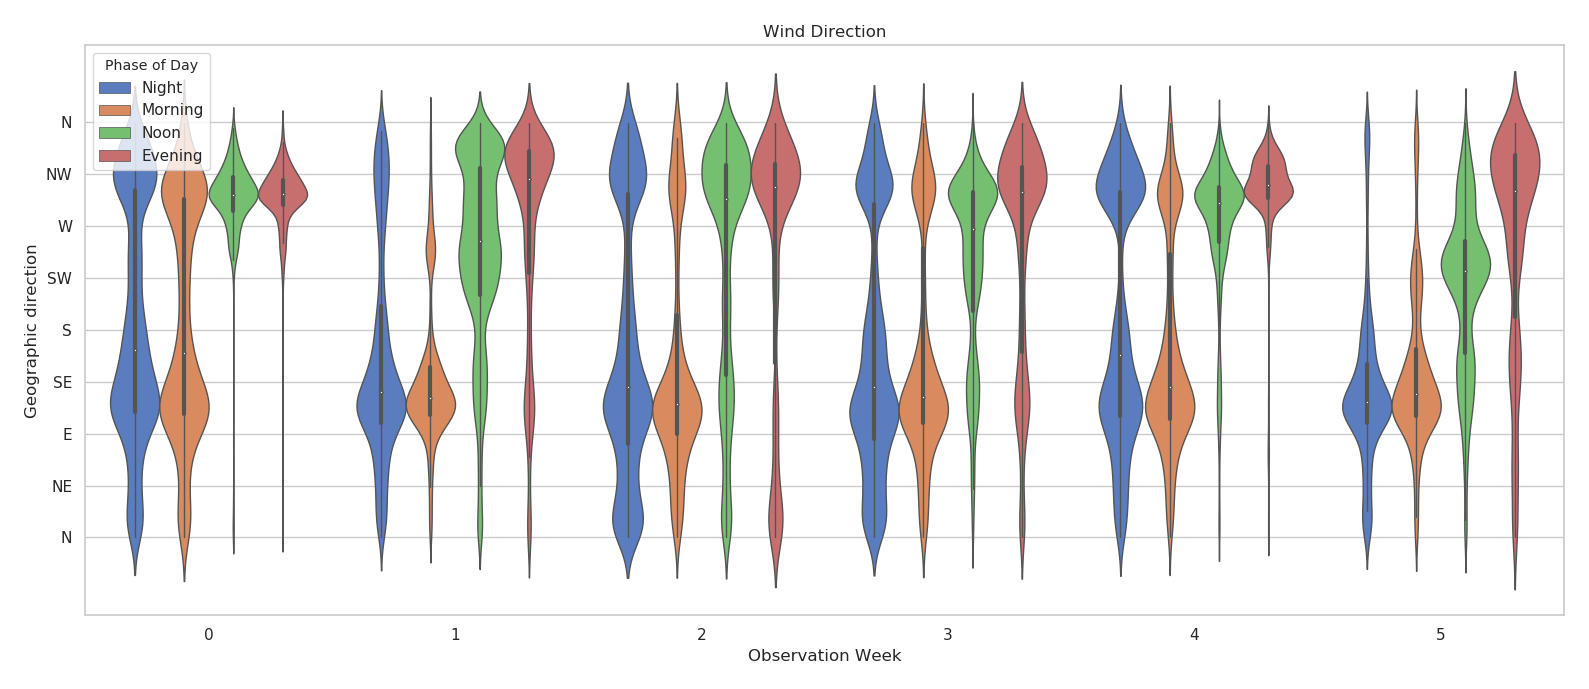

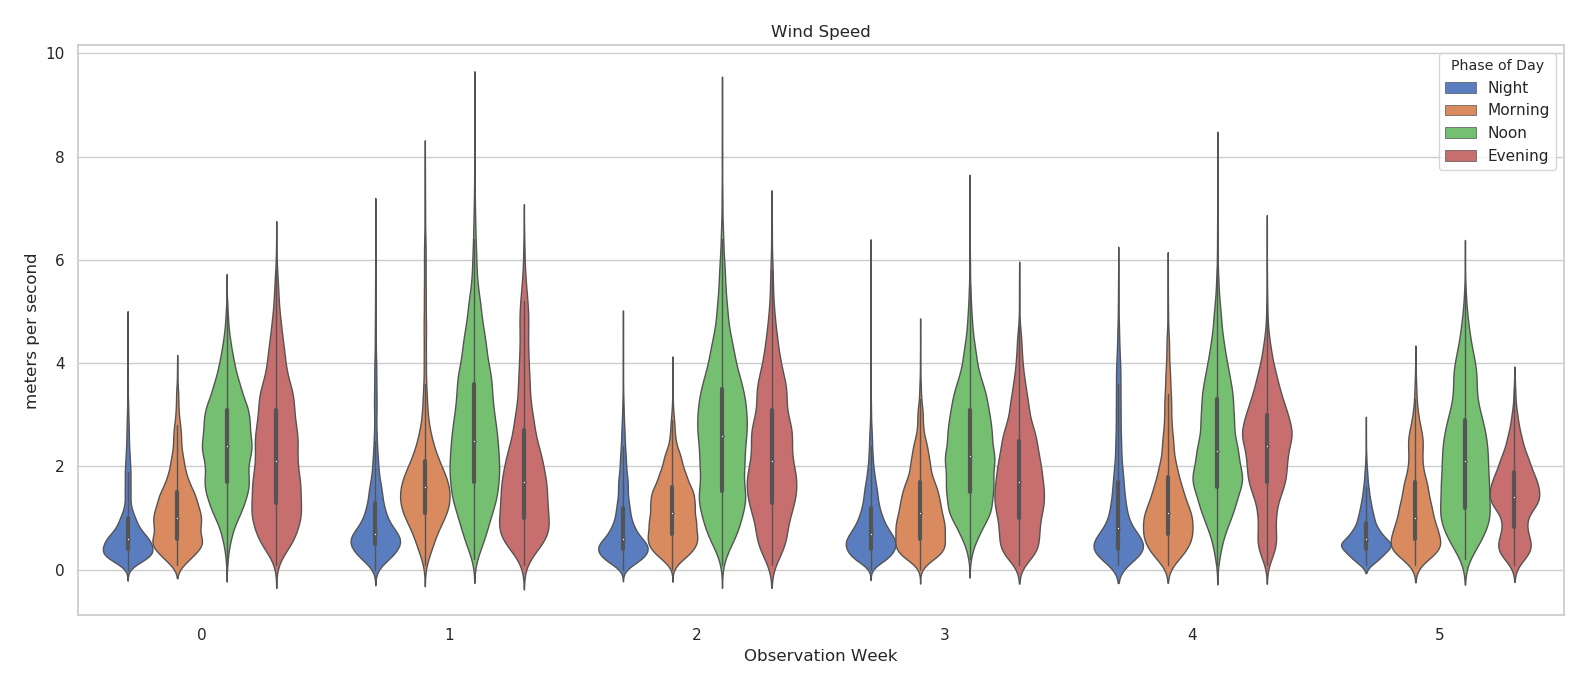

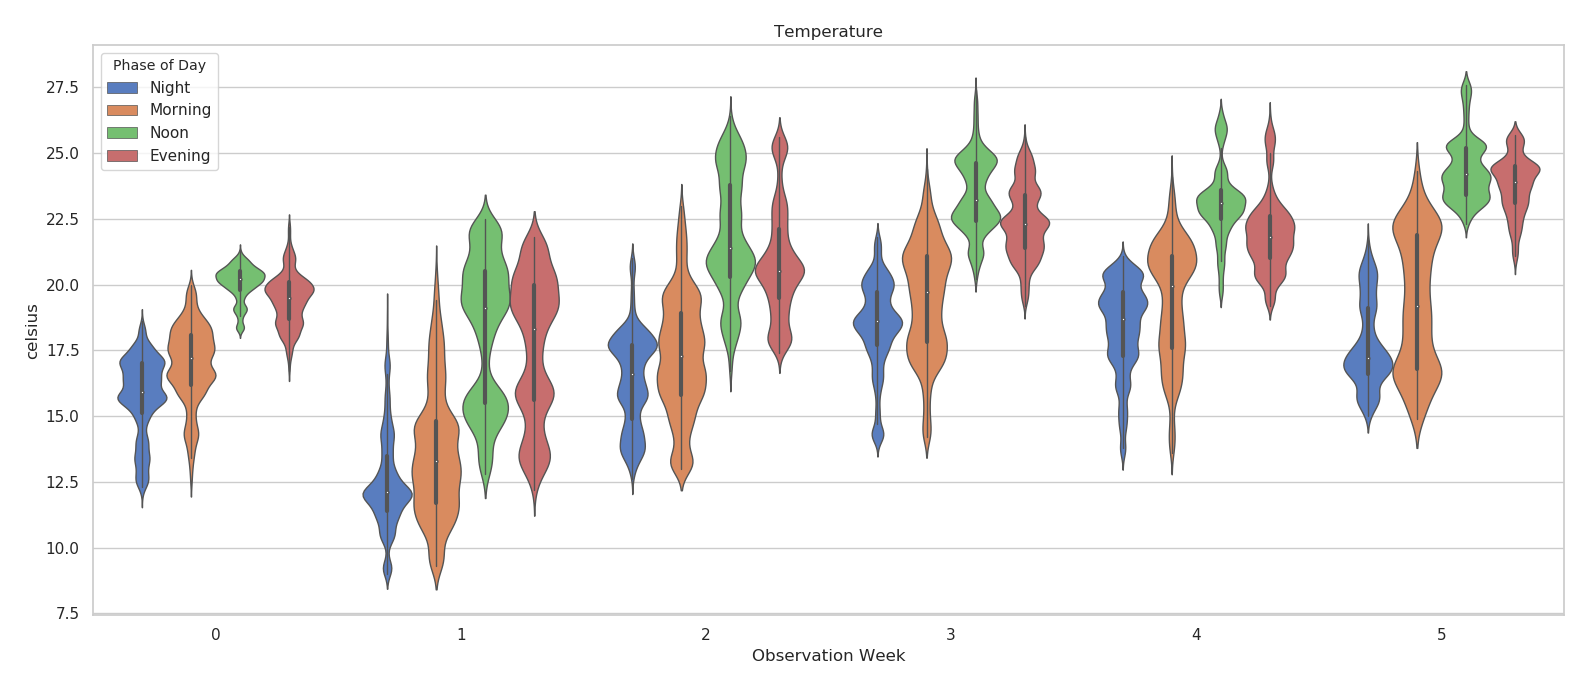

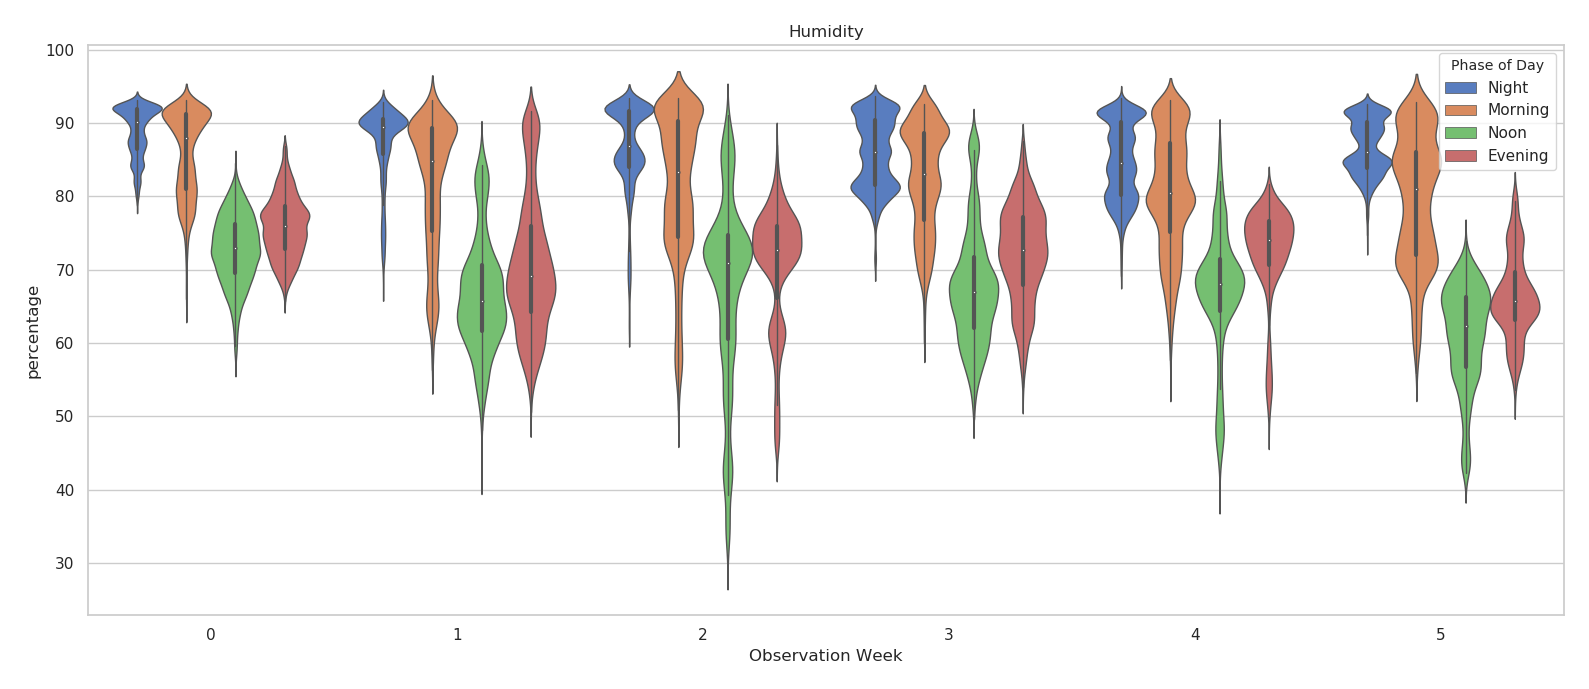

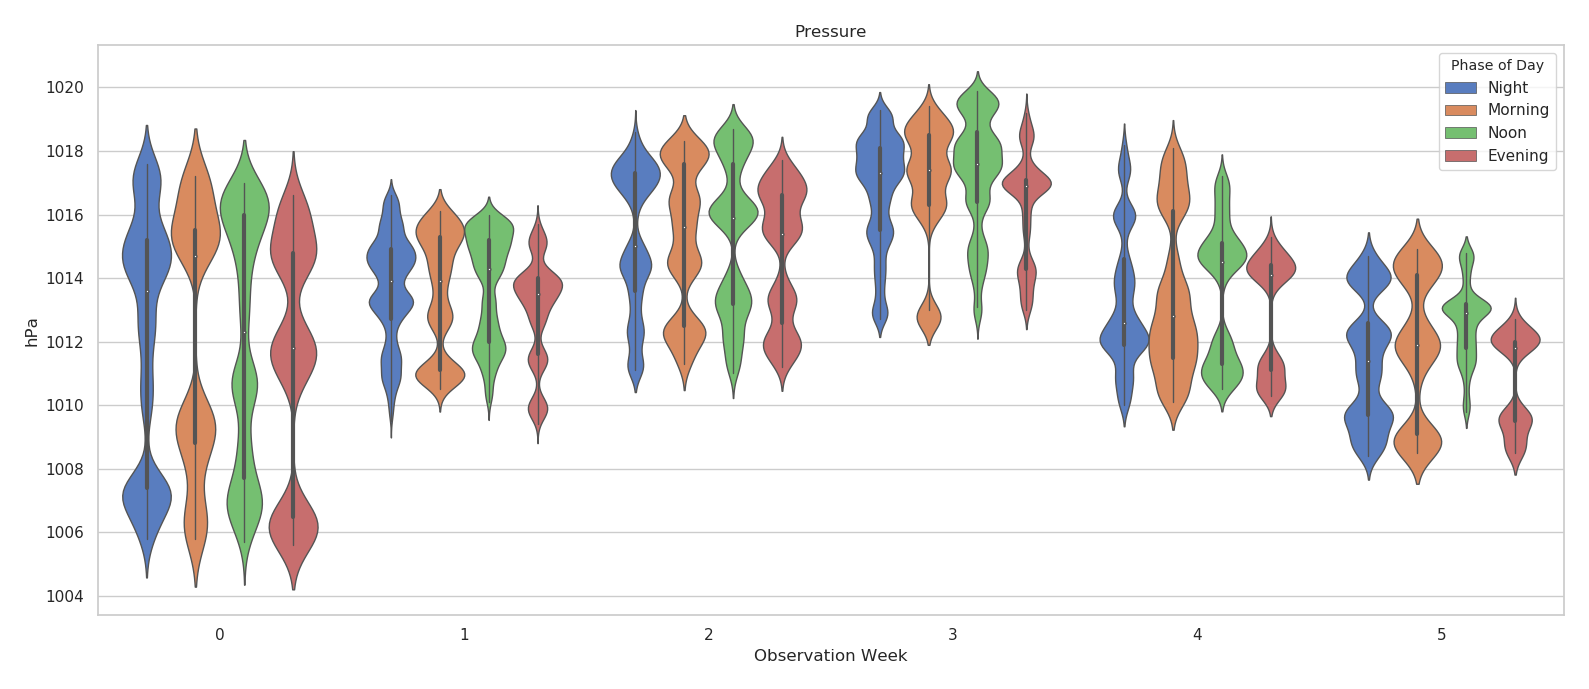

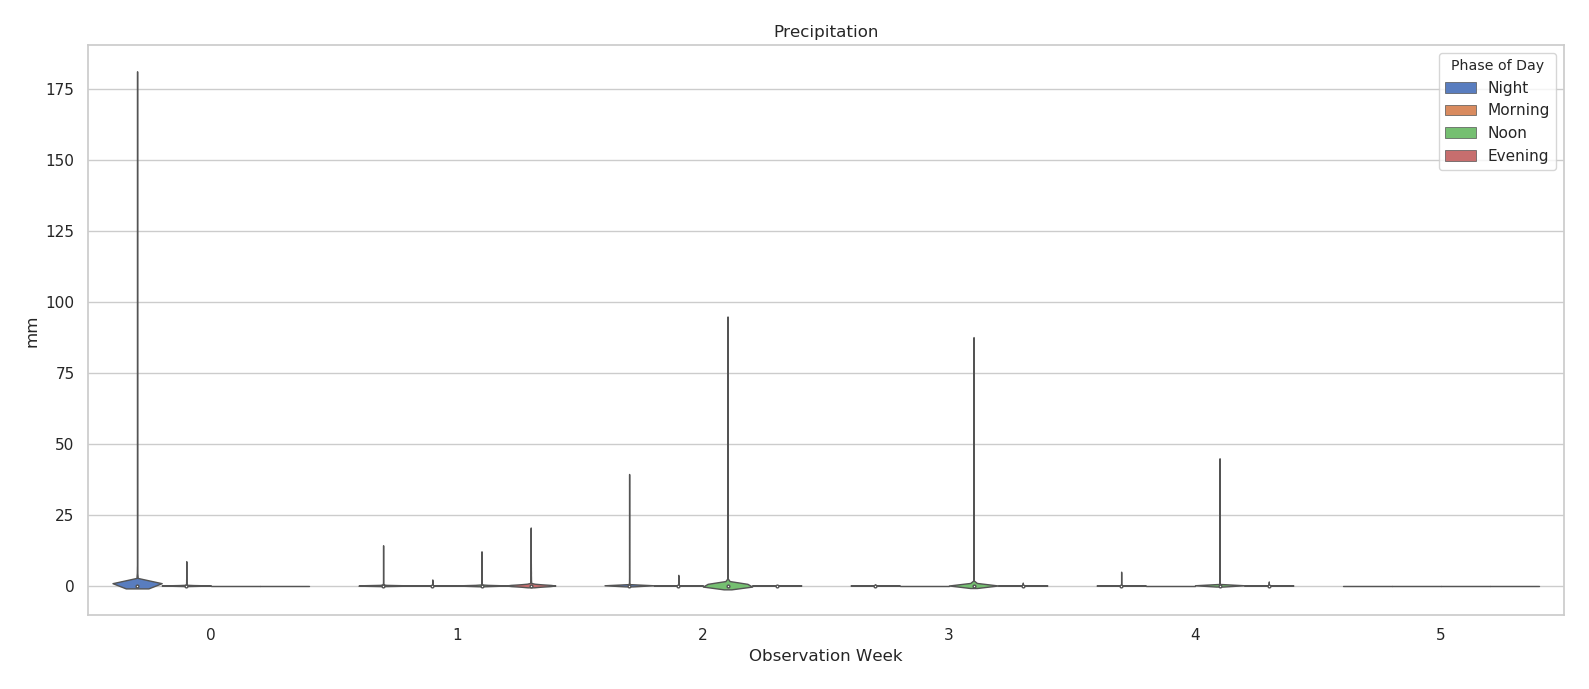

In [38]:
color_palette = itertools.cycle(sns.color_palette())

for index, weather_condition in enumerate(weather_cols):
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1)
    sns.violinplot(x='Week Number', y=weather_condition, hue='Phase of Day',
                   # hue='Day or Night', split=True,
                   data=merged_df, ax=axis,
                   palette='muted', linewidth=1, scale='width',
                   # color=next(color_palette),
                   flierprops=dict(alpha=ALPHA)
                   )

    setAxisLabels(axis, title=weather_condition, xlabel='Observation Week',
                  ylabel=weather_units[weather_condition])
    if weather_condition == 'Wind Direction':
        axis.set_ylabel('Geographic direction')
        axis.set_yticks(ticks = np.arange(0, 361, 45))
        axis.set_yticklabels('N NE E SE S SW W NW N'.split())
    plt.tight_layout()

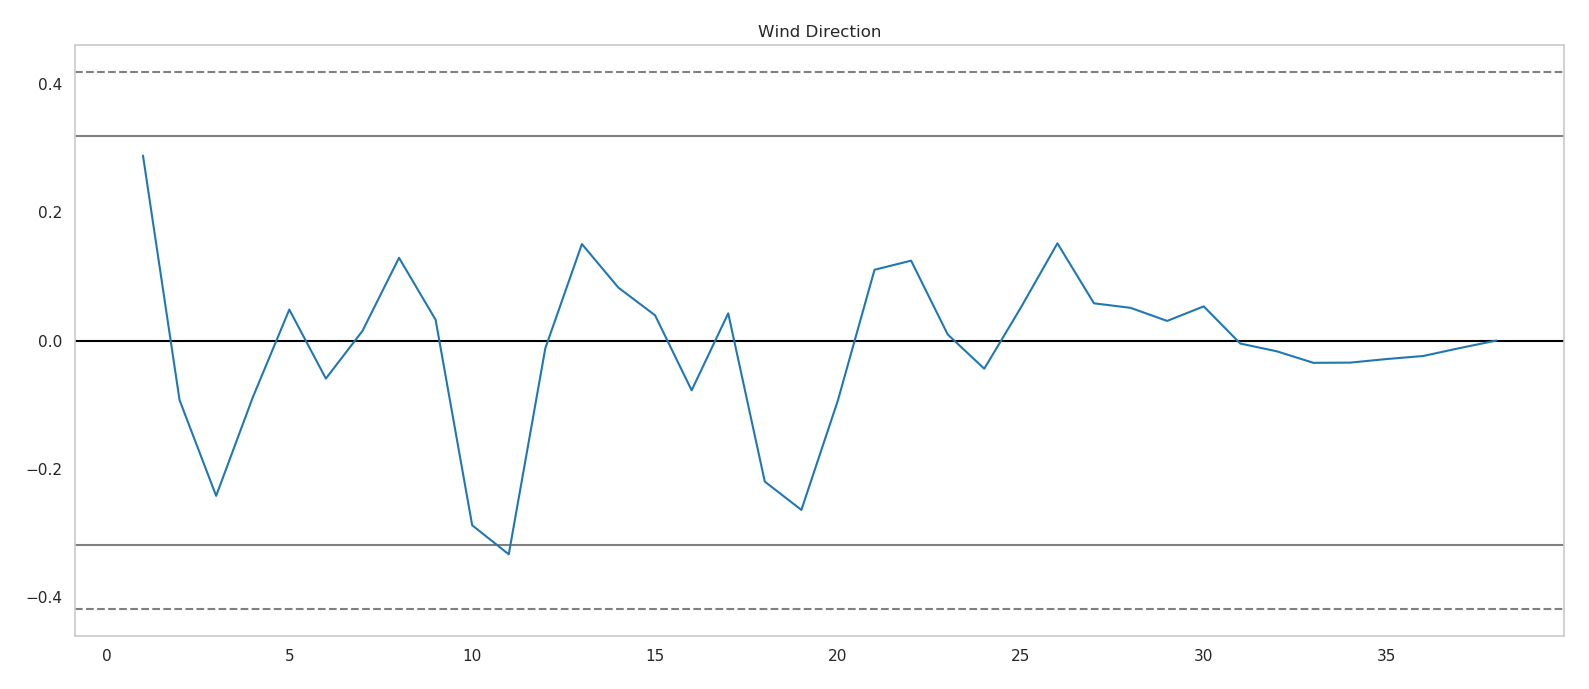

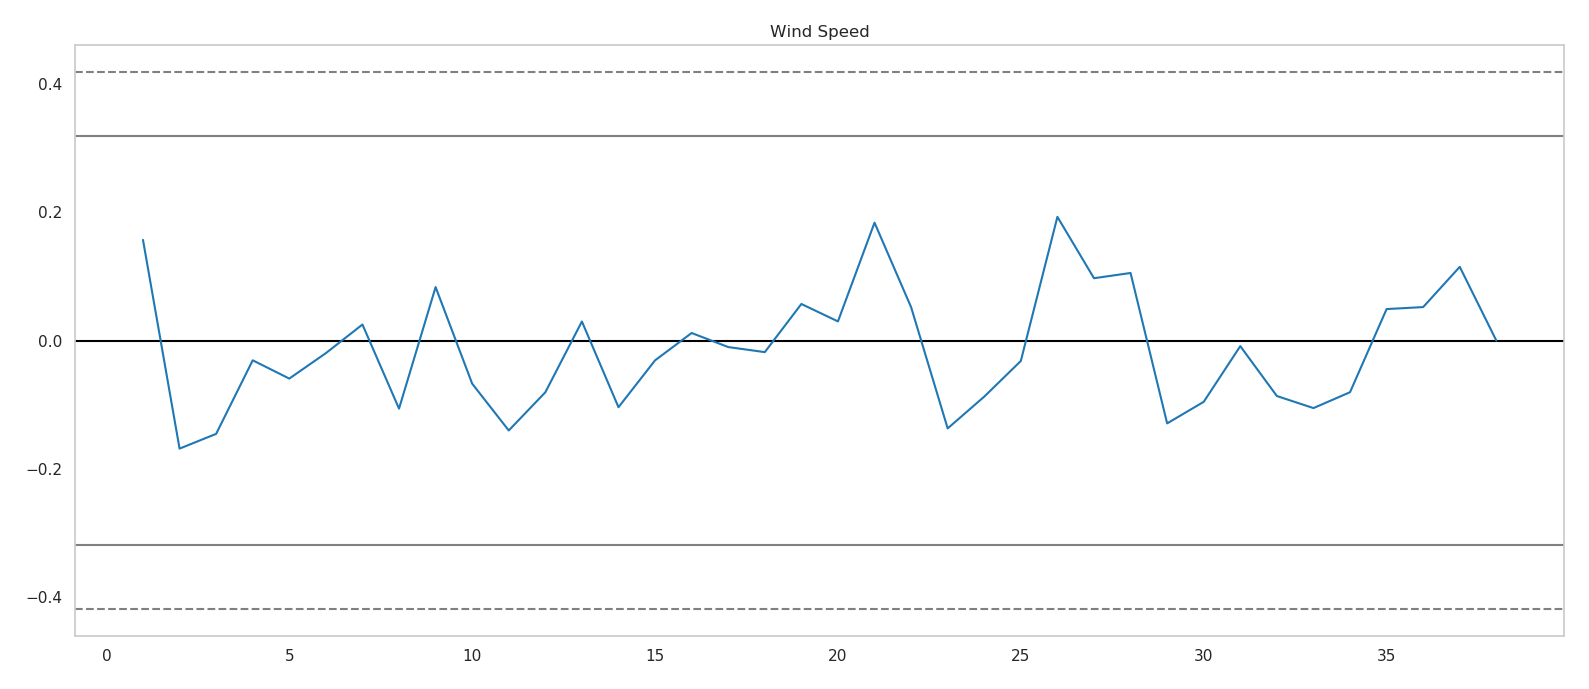

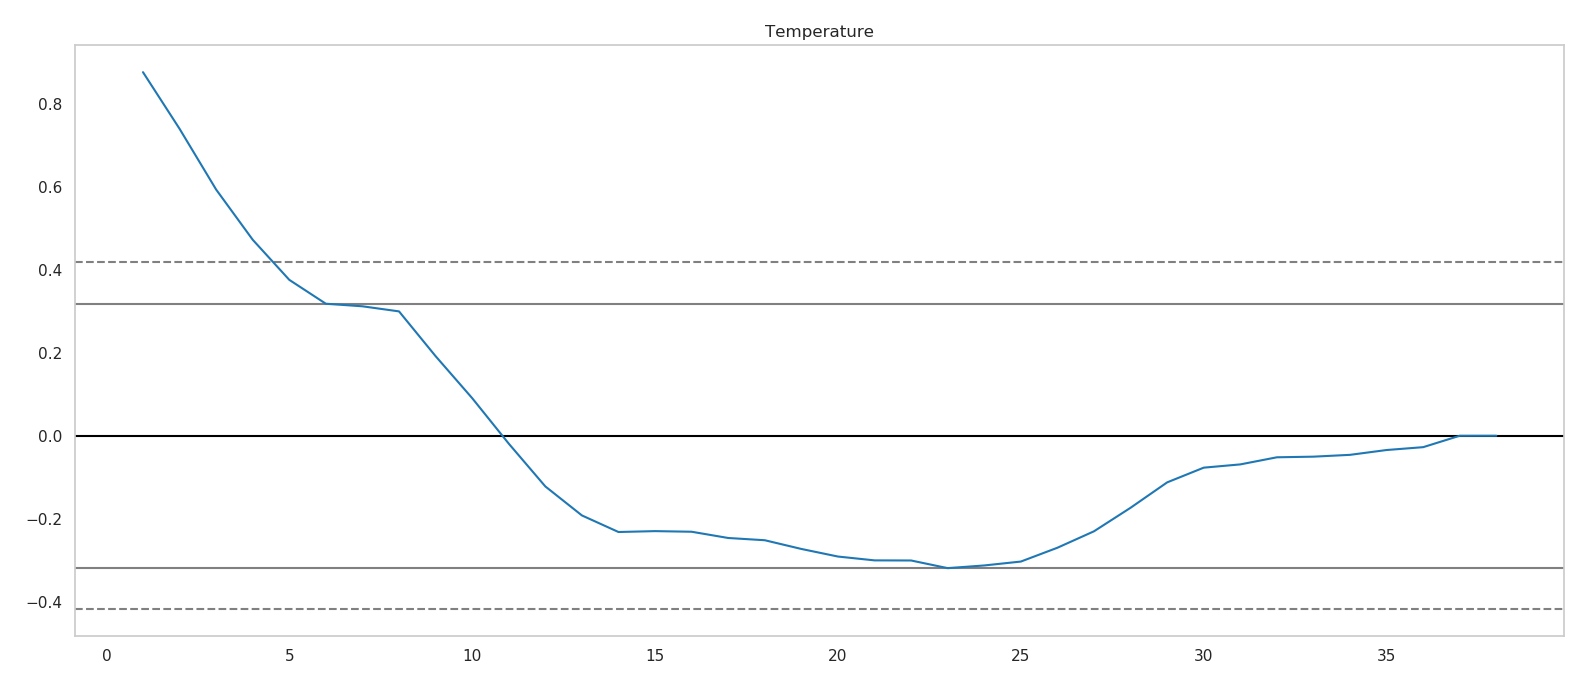

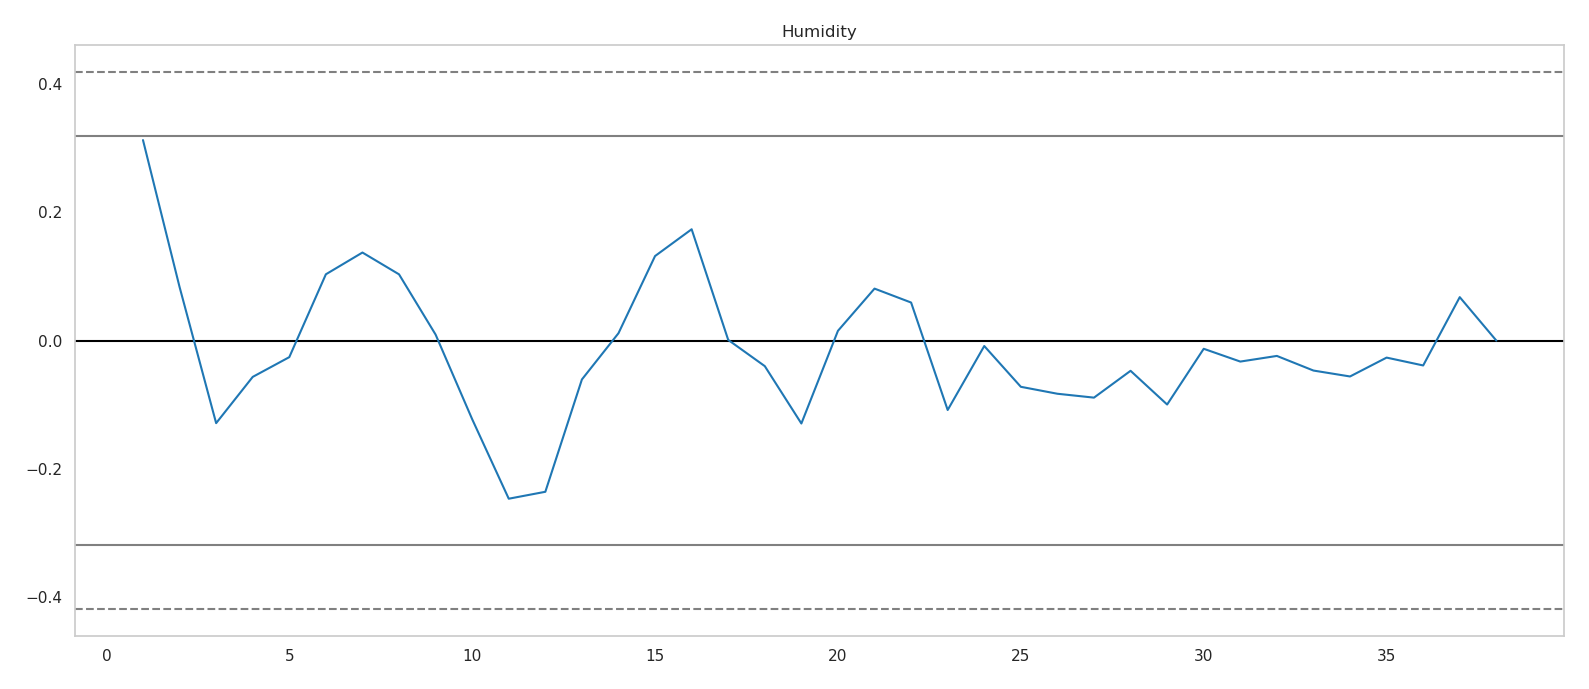

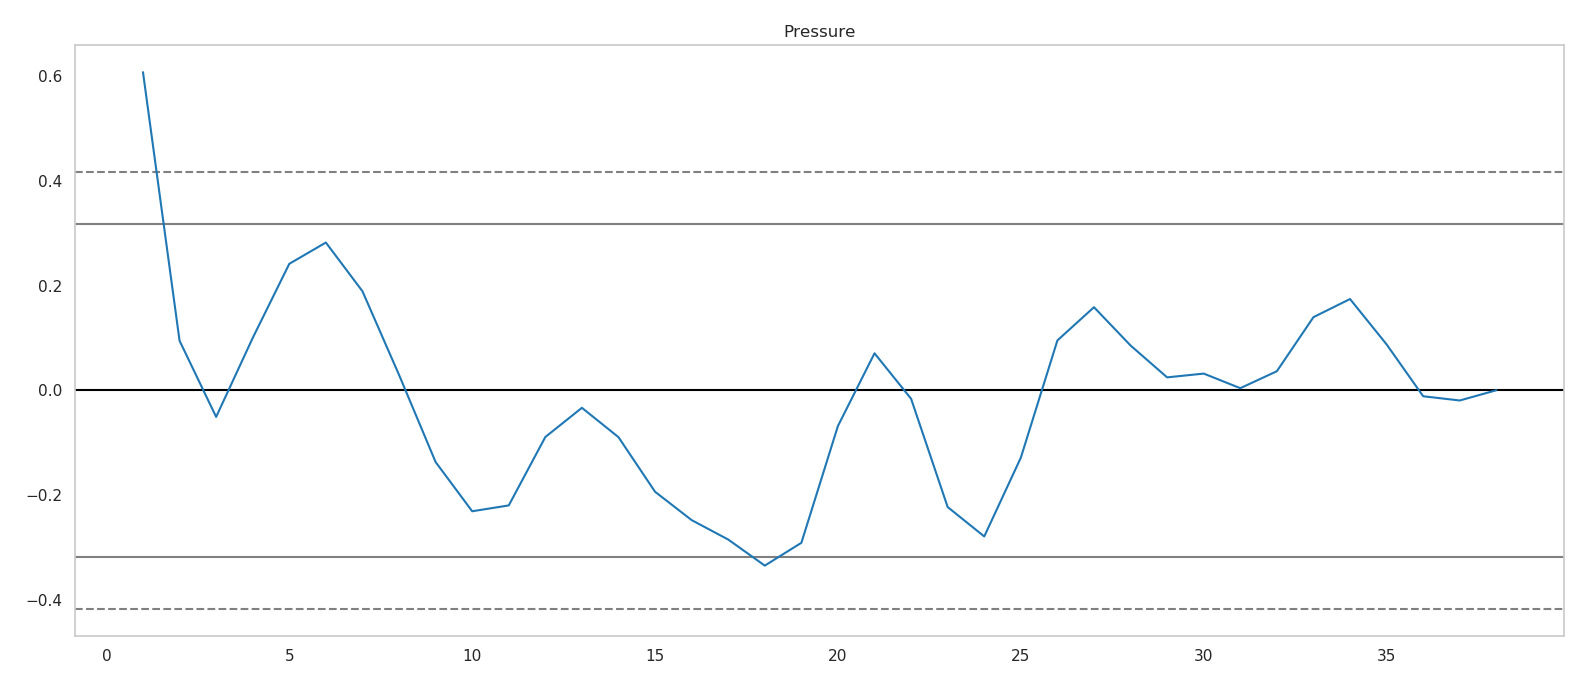

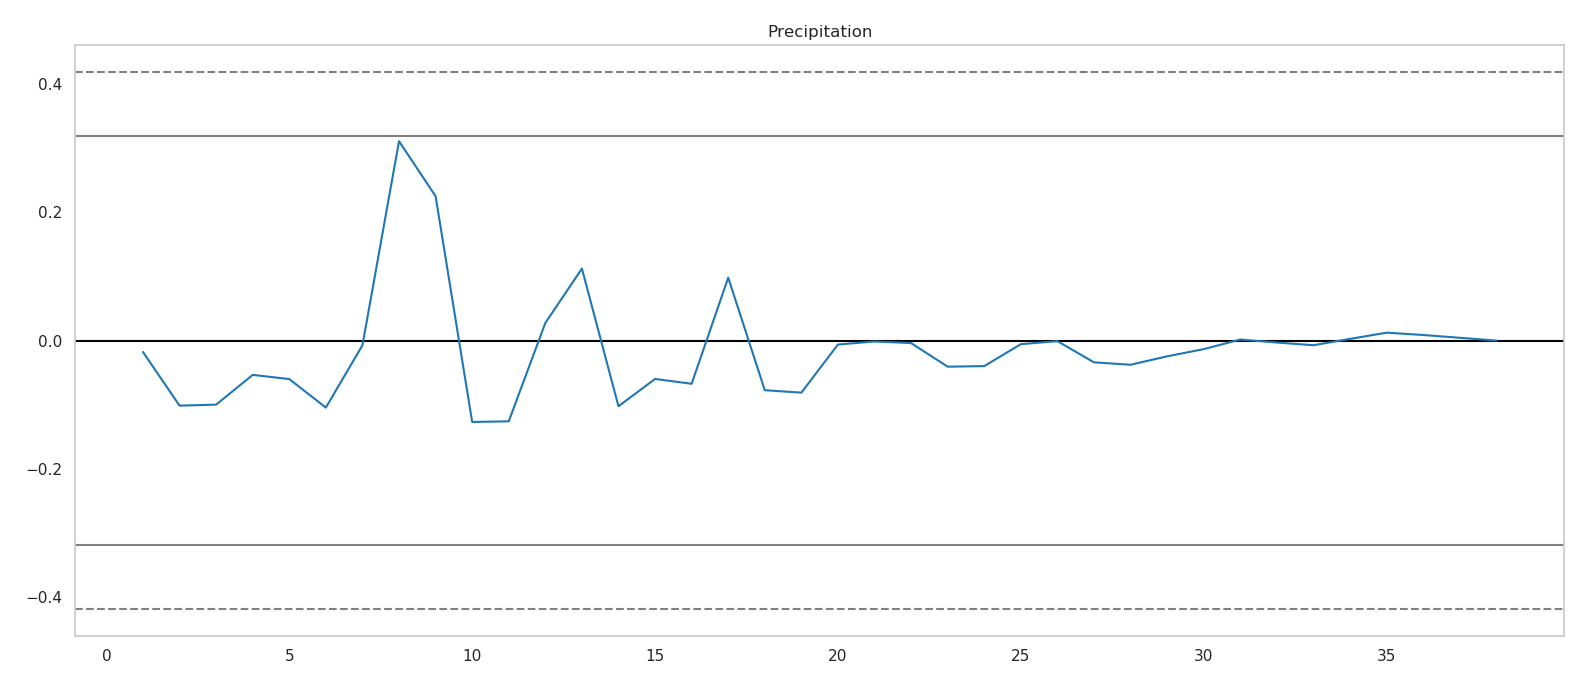

In [39]:
from pandas.plotting import autocorrelation_plot
for index, weather_condition in enumerate(weather_cols):
    fig, axis = plt.subplots()
    autocorrelation_plot(merged_df[weather_condition].resample('D').mean(),
                         ax=axis)

    setAxisLabels(axis, title=weather_condition)
    plt.tight_layout()

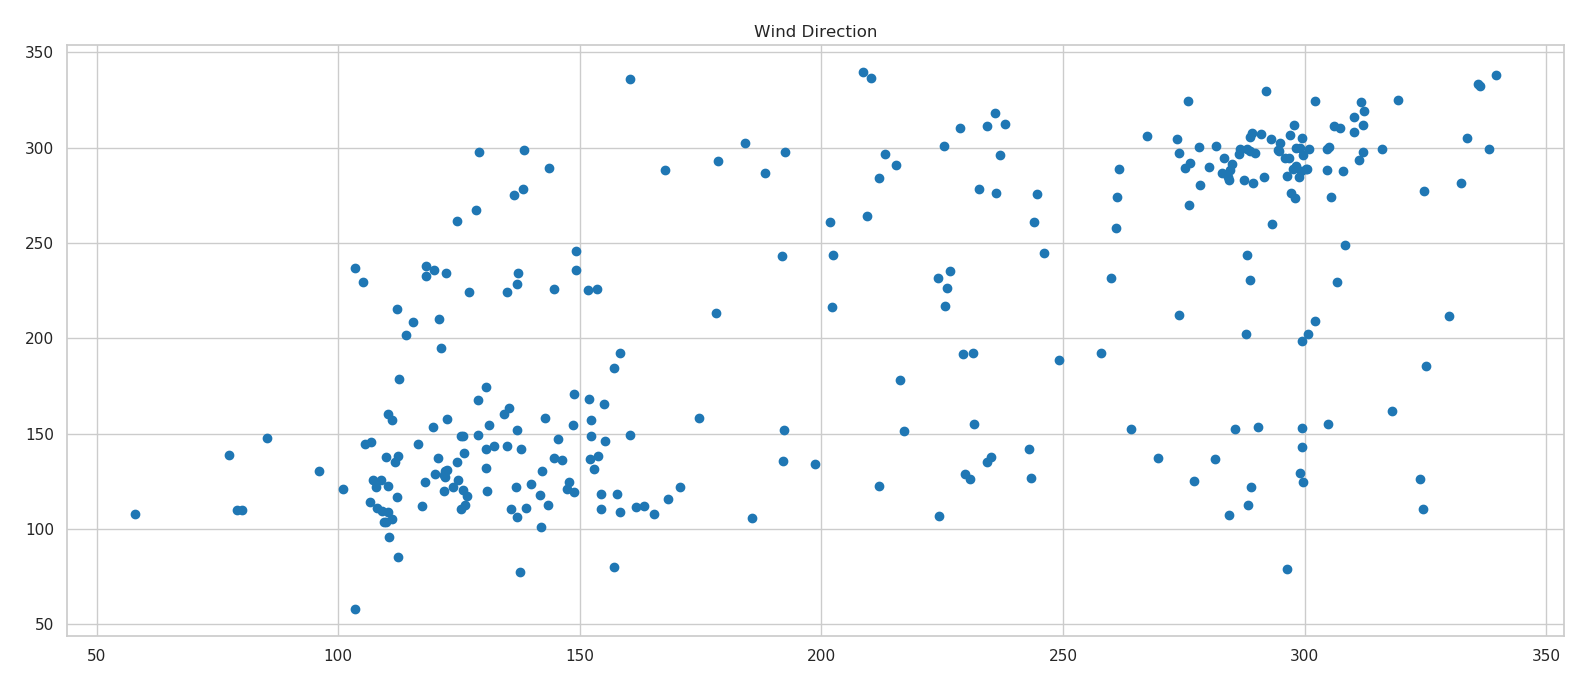

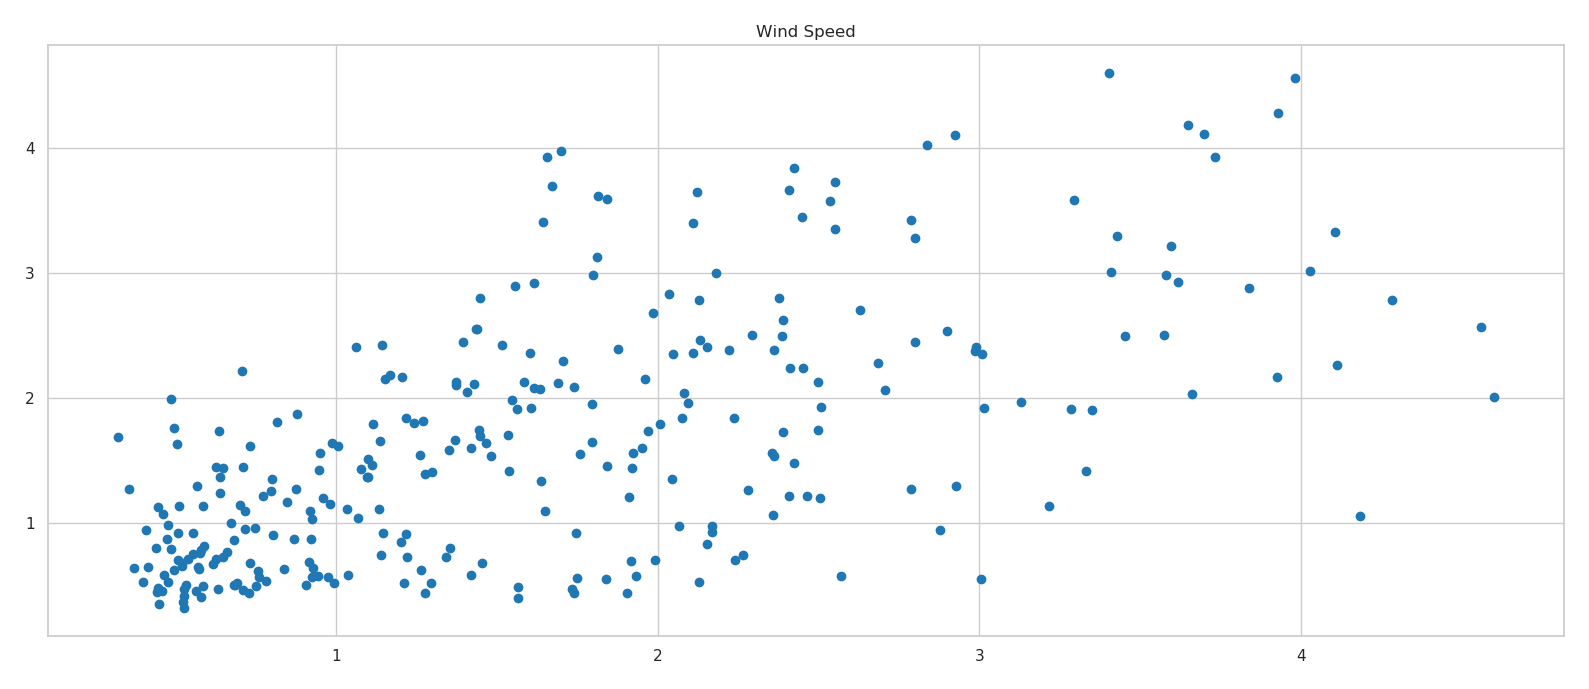

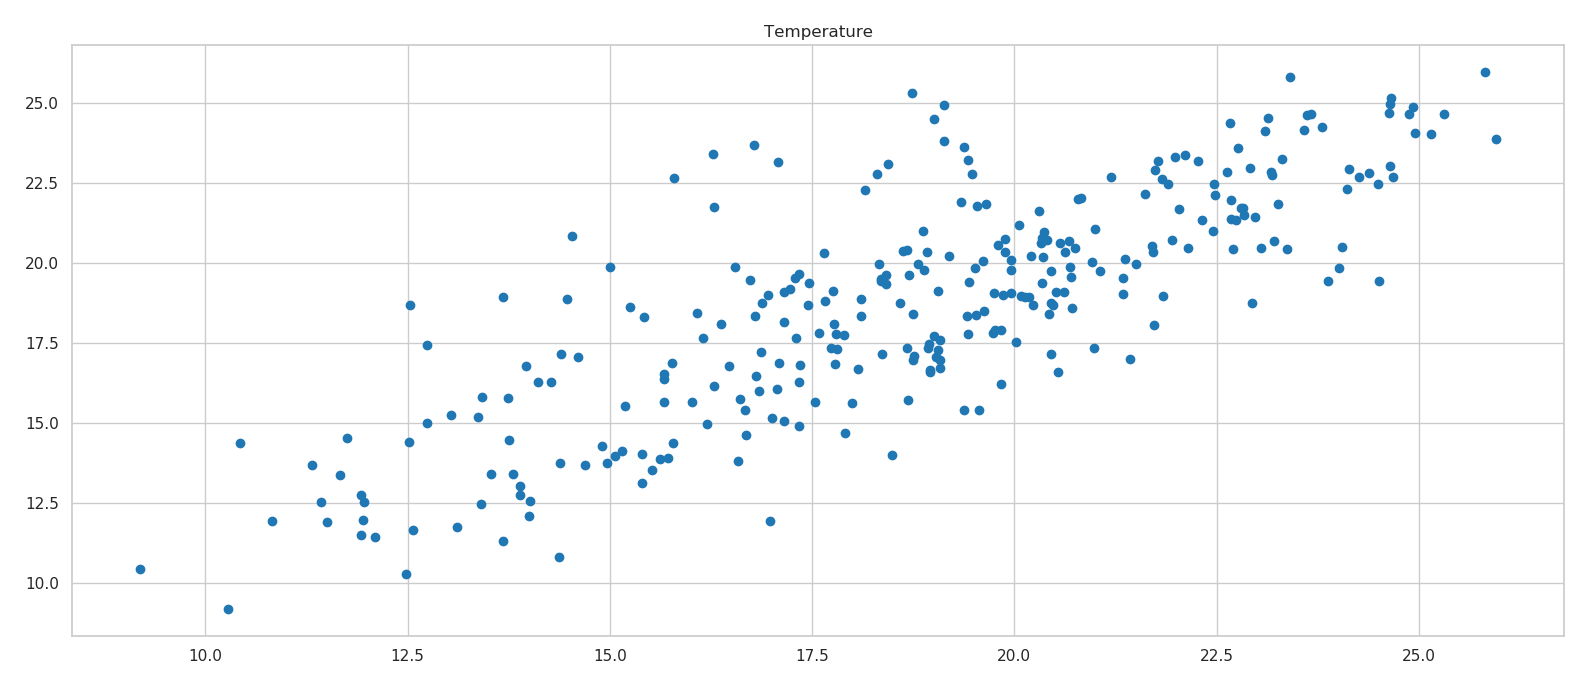

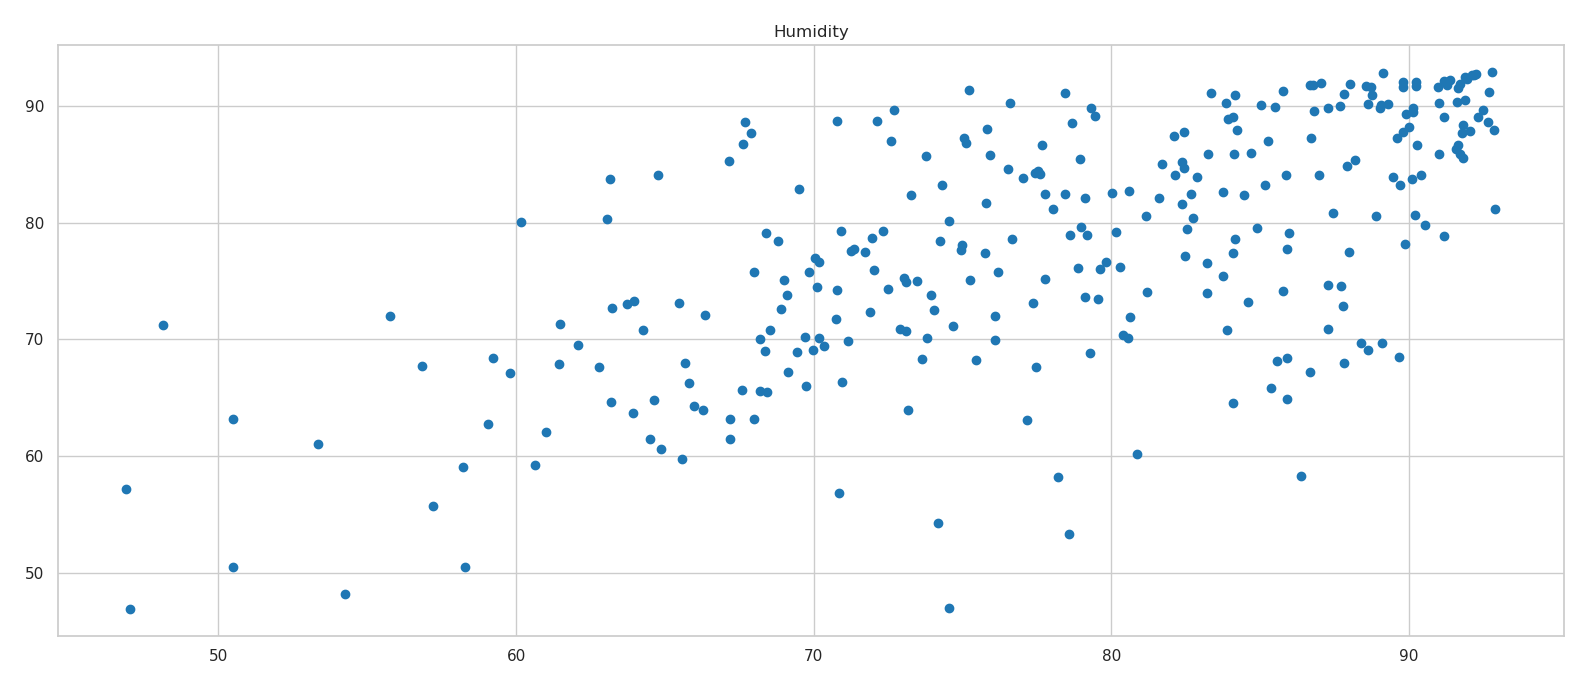

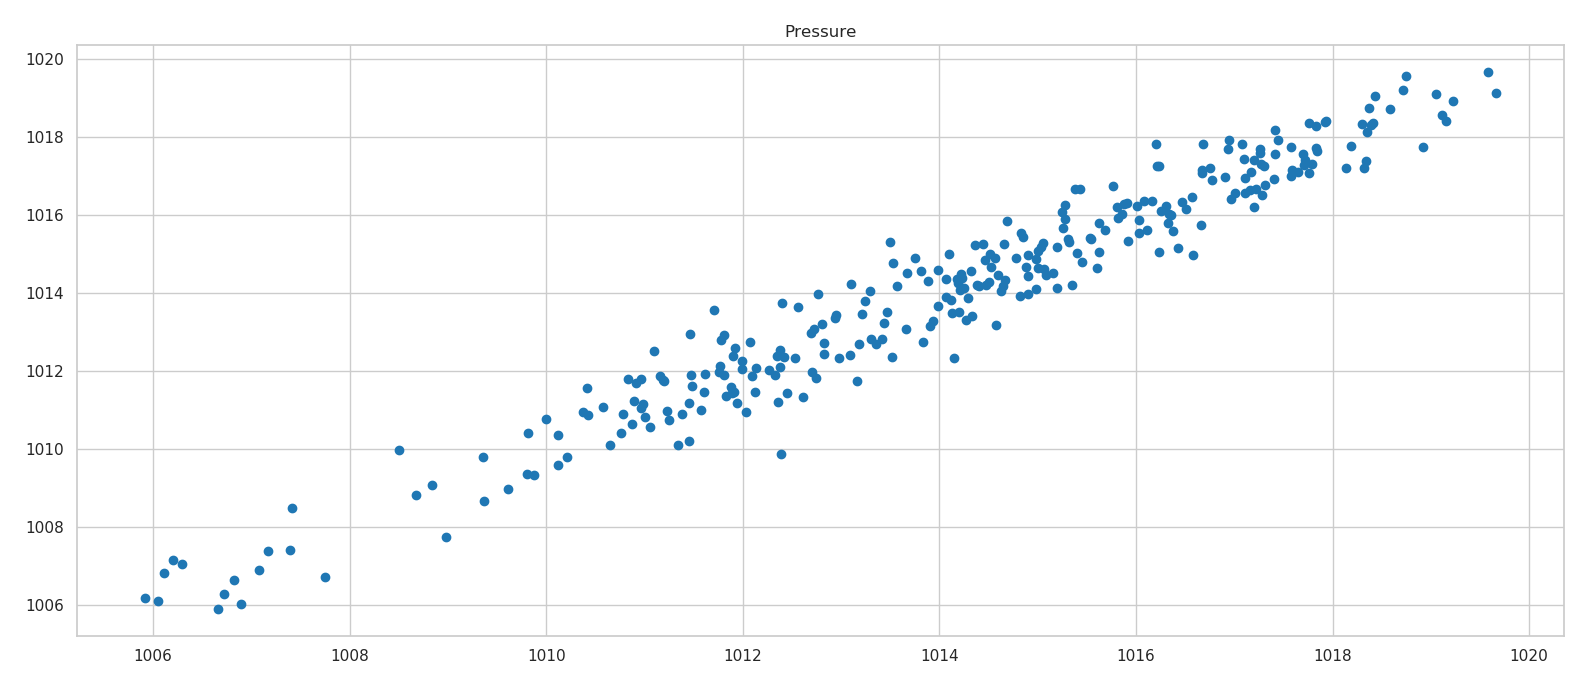

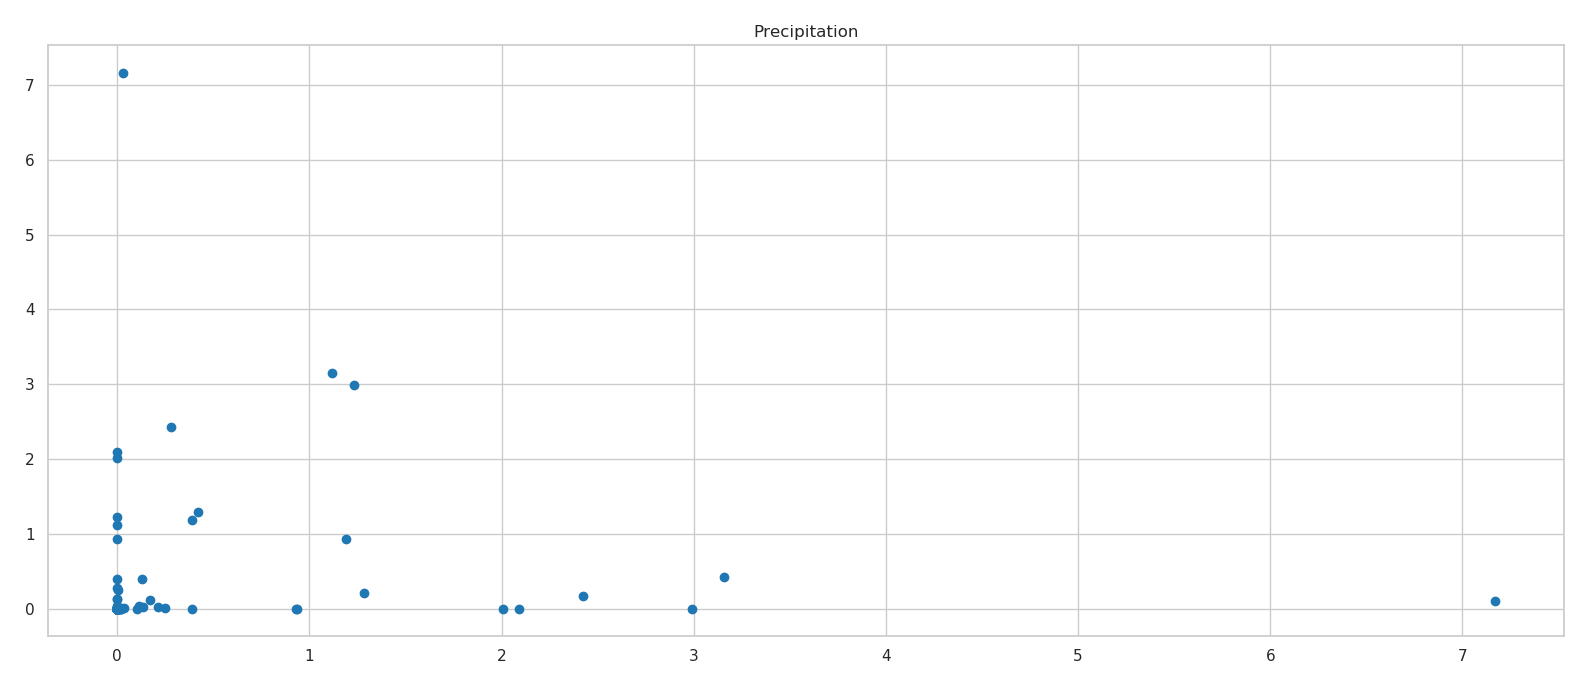

In [40]:
from pandas.plotting import lag_plot
for index, weather_condition in enumerate(weather_cols):
    fig, axis = plt.subplots()
    lag_plot(merged_df[weather_condition].resample('3H').mean(), ax=axis)

    setAxisLabels(axis, title=weather_condition)
    plt.tight_layout()

Next, we create violin plots for *VoC*s data. The top row of the figure 
shows the original values, while the bottom row shows the normalized 
version of the VoC data.

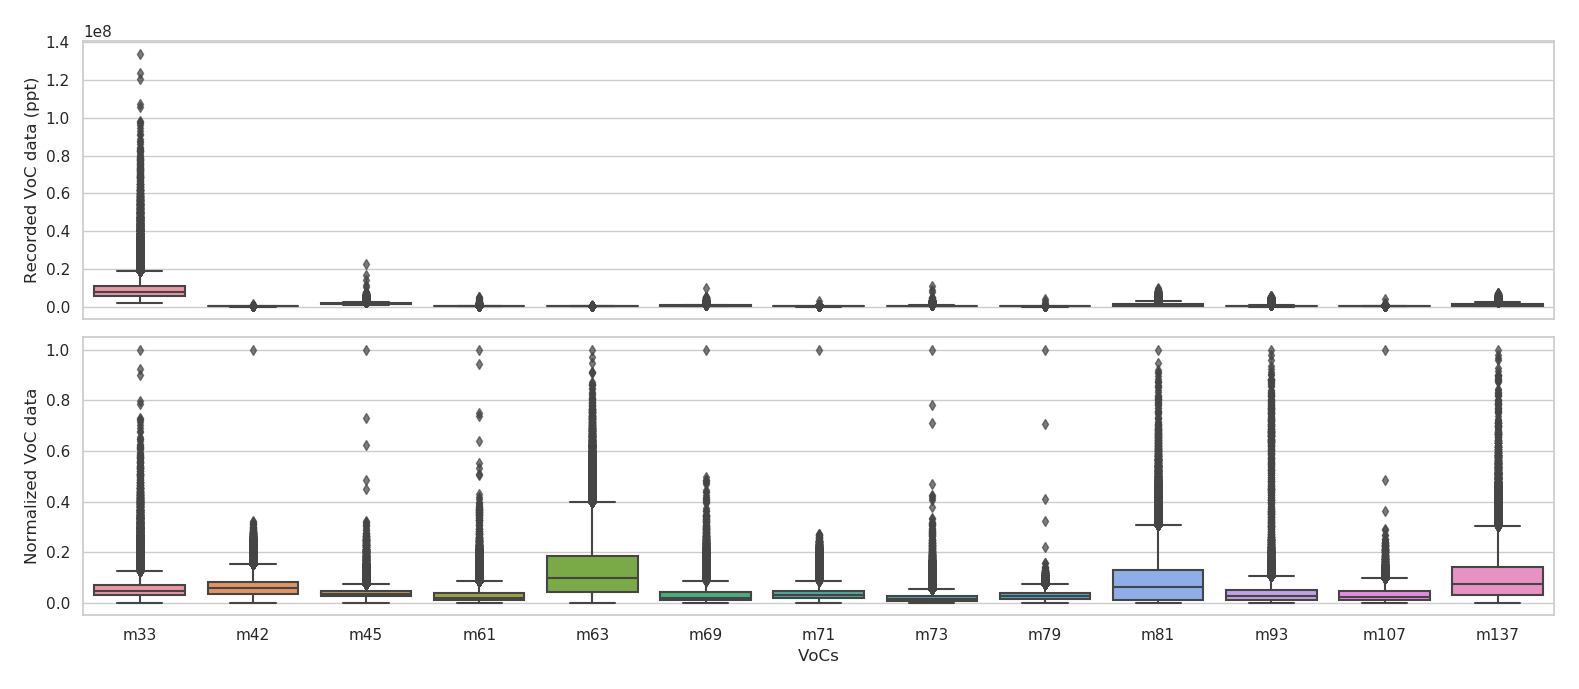

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

setAxisLabels(axes[0], ylabel='Recorded VoC data (ppt)')
sns.boxplot(data=merged_df[voc_cols], ax=axes[0],
            flierprops=dict(alpha=ALPHA, linewidth=0.1))

setAxisLabels(axes[1], xlabel='VoCs', ylabel='Normalized VoC data')
sns.boxplot(data=normalize(merged_df[voc_cols]), ax=axes[1],
            flierprops=dict(alpha=ALPHA, linewidth=0.1))
plt.tight_layout()

The original version of the VoCs data is plotted with the same scale because all values are in *ppt* (converted from ppb, while preprocessing). The boxplot seems to show that m33 or Methanol is the most varying and abundant VoC, although when we normalize the data, it seems that m63 or DMS and m81 or Pinenes are also varying considerably, which points to these VoCs as prime candidates for further investigation.

Next, we create scaled and normalized versions of wind speed.

The scaled version emphasises higher wind speeds while diminishing the impact of lower wind speeds.

In [42]:
scaled_WindSpeed = np.sqrt(np.e**merged_df['Wind Speed'])
normed_WindSpeed = normalize(merged_df['Wind Speed'])

A scatter plot of scaled and normalized wind speed vs. actual wind speed is shown below for comparison. The x-axis shows original wind speeds.

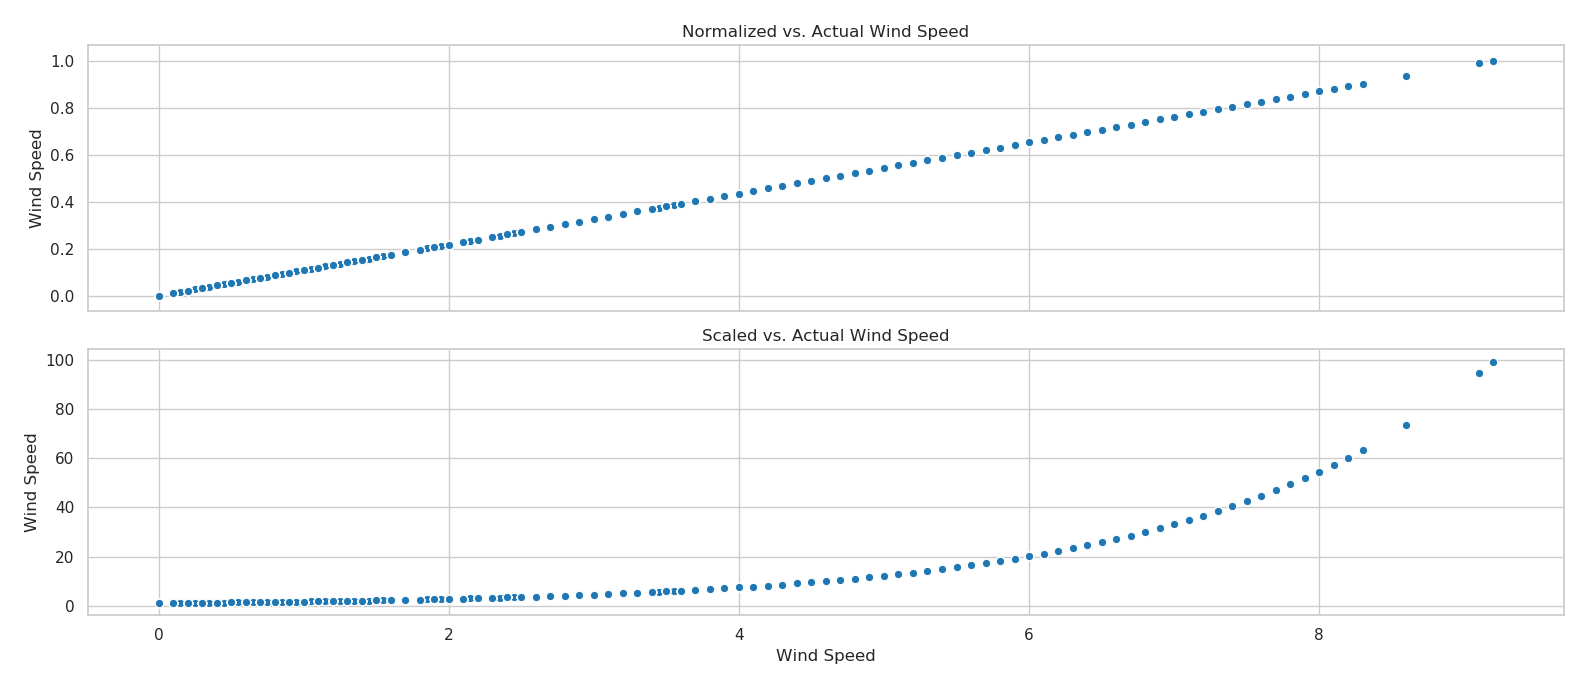

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

setAxisLabels(axes[0], title='Normalized vs. Actual Wind Speed')
sns.scatterplot(merged_df['Wind Speed'], normed_WindSpeed, ax=axes[0])

setAxisLabels(axes[1], title='Scaled vs. Actual Wind Speed')
sns.scatterplot(merged_df['Wind Speed'], scaled_WindSpeed, ax=axes[1])

plt.tight_layout()

Since m81 is a sum of $\alpha$-pinene and $\beta$-pinene, comparing the two and finding consistent levels should indicate that the data is correctly preprocessed.

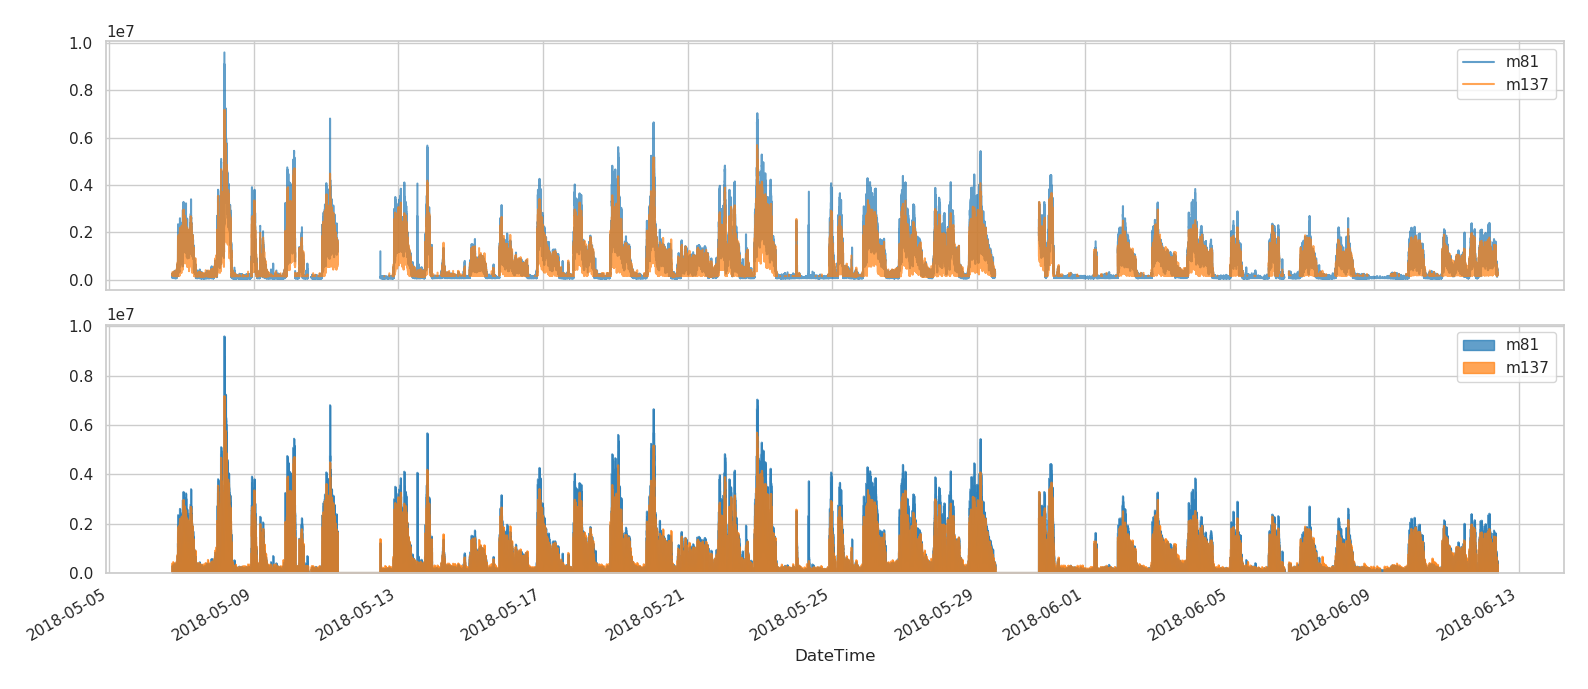

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

merged_df.plot(y=['m81', 'm137'], ax=axes[0], alpha=ALPHA)

merged_df.plot.area(y=['m81', 'm137'], stacked=False, ax=axes[1], alpha=ALPHA)

plt.tight_layout()

The following figure shows the cumulative VoC of pinenes and $\alpha$-pinene, respectively. The VoC concentrations are plotted against wind speed, while the color indicates relatively normalized VoC concentrations ie. the normalization of VoC values for m81 and m137 is performed while considering their mutual min and max values. The size of each point is relative to the scaled wind speed.

/home/atif/anaconda3/envs/mapping/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)
/home/atif/anaconda3/envs/mapping/lib/python3.7/site-packages/matplotlib/colors.py:1272: RuntimeWarning: invalid value encountered in less
  resdat[resdat < 0] = 0


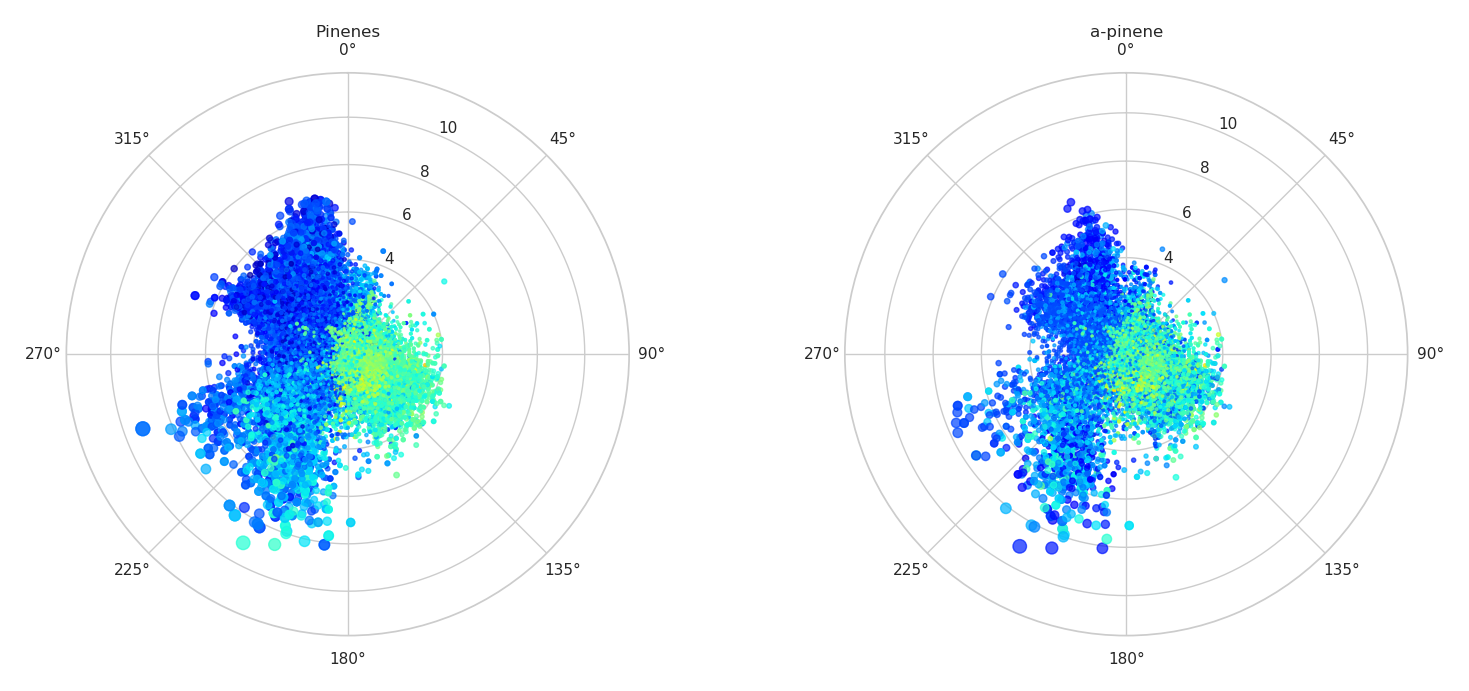

In [45]:
fig = plt.figure()

normed_df = normalize(merged_df[['m81', 'm137']], True)

for ind, voc in enumerate(['m81', 'm137']):
    axis = fig.add_subplot(1, 2, ind+1, projection='polar')
    adjustProjection(axis)
    axis.set_title(voc_dict[voc])
    normed_voc = normed_df[voc]
    axis.scatter(np.radians(merged_df['Wind Direction']), merged_df['Wind Speed'],
                 s=scaled_WindSpeed, c=normed_voc, cmap='jet', alpha=ALPHA,
                 norm=mpl.colors.PowerNorm(gamma=0.3))

plt.tight_layout()

The following figures show the concentration levels of Isoprene and its oxygenated version on a polar plot, respectively. The angle is showing the wind direction at the time of VoC observation and the distance from the origin is showing the normalized wind speed. The color of each point shows the mutually normalized concentration of the VoCs i.e. normalization was performed with global min and max for the two VoCs. The size of each point is showing the scaled wind speed.

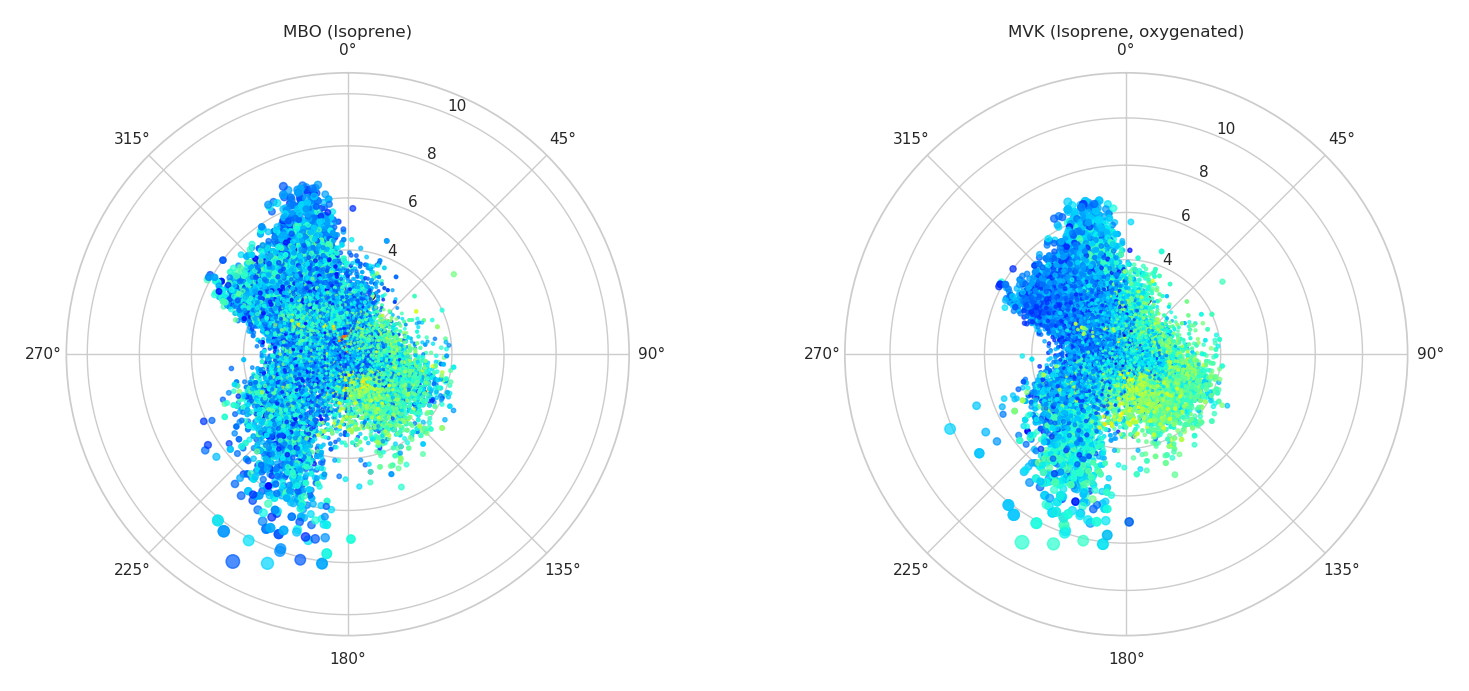

In [46]:
fig = plt.figure()

normed_df = normalize(merged_df[['m69', 'm71']], True)

for ind, voc in enumerate(['m69', 'm71']):
    axis = fig.add_subplot(1, 2, ind+1, projection='polar')
    adjustProjection(axis)
    axis.set_title(voc_dict[voc])
    normed_voc = normed_df[voc]
    axis.scatter(np.radians(merged_df['Wind Direction']), merged_df['Wind Speed'],
                 s=scaled_WindSpeed, c=normed_voc, cmap='jet', alpha=ALPHA,
                 norm=mpl.colors.PowerNorm(gamma=0.3))

plt.tight_layout()

Since we only have a single data source for the weather conditions and VoCs, we cannot calculate a gradient of the VoCs i.e. we don't have any initial and final concentration values over a given time, therefore, we cannot calculate second order equations for the VoCs based on their rate coefficients.

To approximate the distance travelled by the different VoCs based on the wind speed alone, we can compute a cumulative distance variable based on the wind speed and wind direction to help us approximate the longest distance a VoC has travelled while the wind is coming from a given direction.

The idea is that based on a general wind direction, a crude approximation of the distance travelled by the wind borne VoCs might be approximated based on the cumulative distance travelled by the wind while coming in specifically from that direction.

Therefore, if the wind is coming from due west (or 270 degrees), and we consider a wind direction to be generally the same given a change of +/- 10 degrees in the wind direction, then as long as the wind is coming in from 260 degrees to 280 degrees, we accumulate the instantaneous distance based on instantaneous wind speeds.

In [47]:
def add_cumu_dist(quantization_block_size=1):
    quantized_WindDirection = np.floor_divide(merged_df['Wind Direction'],
                                         quantization_block_size)
    s = quantized_WindDirection.ne(quantized_WindDirection.shift()).cumsum()
    merged_df['Cumu_Dist'] = merged_df.groupby(s)['Instantaneous Distance'].cumsum()
    del quantized_WindDirection, s

merged_df.insert(column='Cumu_Dist', loc=3, value=np.NaN)

The following plots show:
- Wind Direction against Instantaneous Distance traveled by the Wind at each measurement time
- Wind Direction against Cumulative Distance traveled by the Wind in the same direction (see $\theta$ variable definition for currently used value)

Each dot represents the instantaneous/cumulative distance the wind has travelled.
The size of the dots is relative to the scaled wind speed, a smaller dot represents low speed winds, a larger dot represents high speed winds. The color is based on the normalized wind speed values.
The following plots show the cumulative distance for theta = 5, 10, and 15 degrees, respectively.

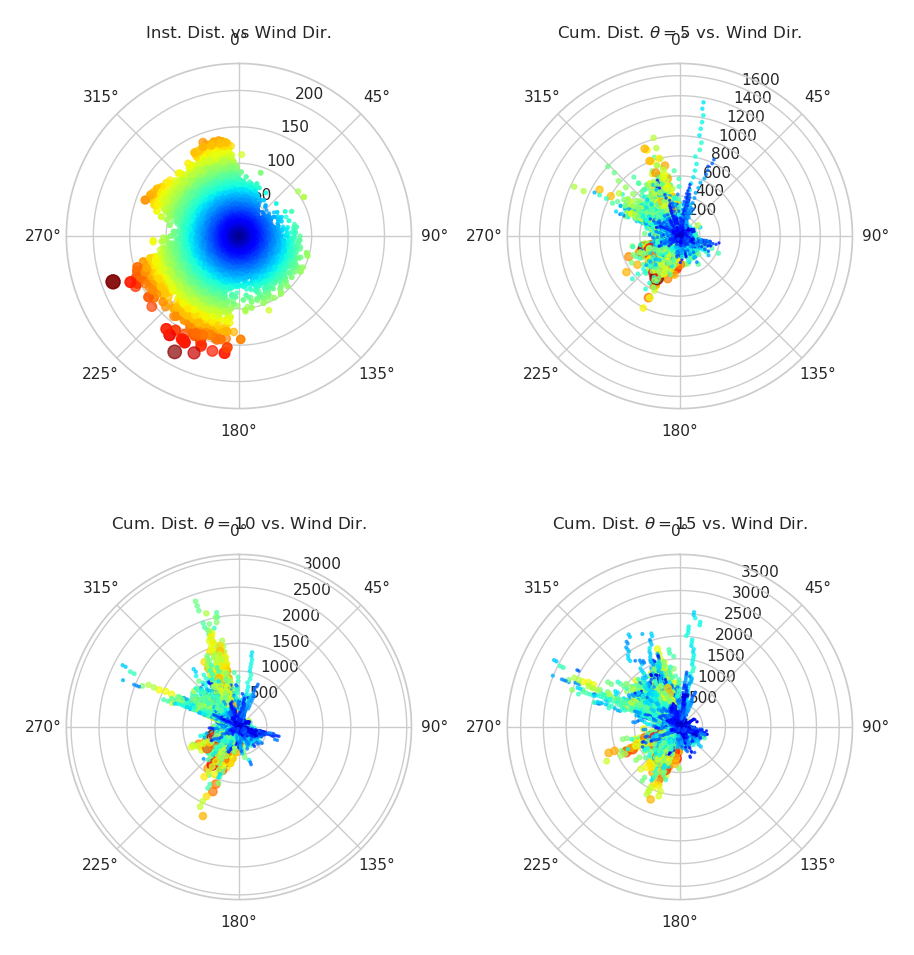

In [48]:
fig = plt.figure(figsize=(9, 10))

axis = fig.add_subplot(2, 2, 1, projection='polar')
adjustProjection(axis)
setAxisLabels(axis, title='Inst. Dist. vs Wind Dir.')
axis.scatter(np.radians(merged_df['Wind Direction']), merged_df['Instantaneous Distance'],
             s=scaled_WindSpeed, c=normed_WindSpeed, cmap='jet', alpha=ALPHA)

theta_width = 5
add_cumu_dist(theta_width)

axis = fig.add_subplot(2, 2, 2, projection='polar')
adjustProjection(axis)
setAxisLabels(axis, title=r'Cum. Dist. $\theta = 5$ vs. Wind Dir.')
axis.scatter(np.radians(merged_df['Wind Direction']), merged_df.Cumu_Dist,
             s=scaled_WindSpeed, c=normed_WindSpeed, cmap='jet', alpha=ALPHA)

theta_width = 10
add_cumu_dist(theta_width)

axis = fig.add_subplot(2, 2, 3, projection='polar')
adjustProjection(axis)
setAxisLabels(axis, title=r'Cum. Dist. $\theta = 10$ vs. Wind Dir.')
axis.scatter(np.radians(merged_df['Wind Direction']), merged_df.Cumu_Dist,
             s=scaled_WindSpeed, c=normed_WindSpeed, cmap='jet', alpha=ALPHA)

theta_width = 15
add_cumu_dist(theta_width)

axis = fig.add_subplot(2, 2, 4, projection='polar')
adjustProjection(axis)
setAxisLabels(axis, title=r'Cum. Dist. $\theta = 15$ vs. Wind Dir.')
axis.scatter(np.radians(merged_df['Wind Direction']), merged_df.Cumu_Dist,
             s=scaled_WindSpeed, c=normed_WindSpeed, cmap='jet', alpha=ALPHA)

plt.tight_layout()

The above plots show that this cumulative distance measure is highly dependant on the theta value, although we do see some consistancy in the colors.

Next, we are plotting the Instantaneous distance against wind direction with point size relative to the scaled wind speed and color corresponding to the mutually normalized VoC concentrations. The colors are associated based on a power norm i.e. the color values are assigned based on normalized value raised to a fraction so that lower values are emphasised more than higher (possibly noisy values).

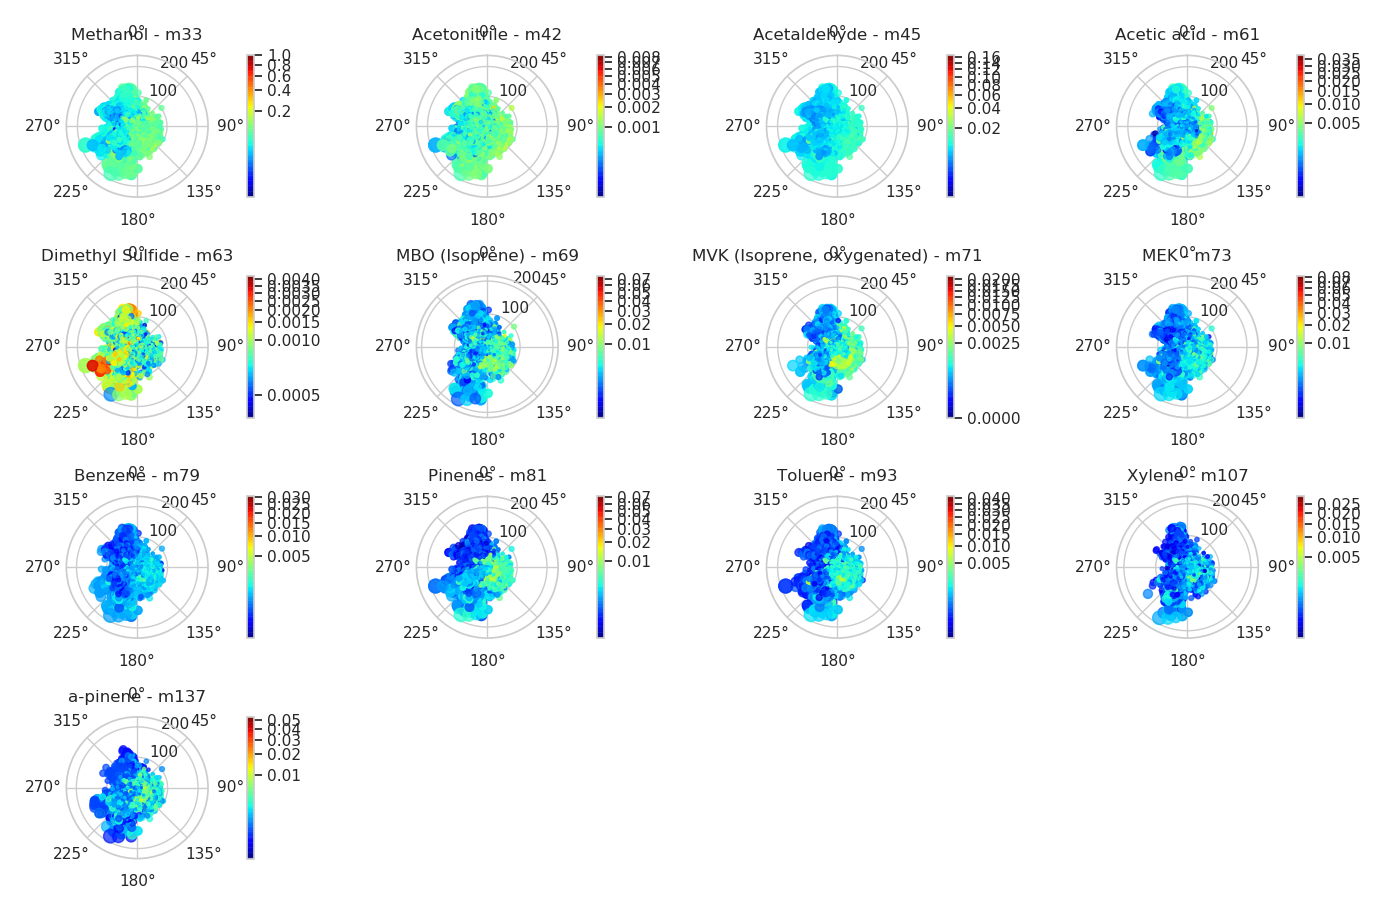

In [49]:
fig = plt.figure(figsize=(14, 9))

# lower_lim = merged_df[voc_cols].quantile(0.25).min()
# upper_lim = merged_df[voc_cols].quantile(0.75).max()

# normed_df = normalize(merged_df[voc_cols].clip(lower=lower_lim,
#                                                upper=upper_lim,
#                                                axis=1), True)
normed_df = normalize(merged_df[voc_cols], True)

for ind, voc in enumerate(voc_cols):
    axis = fig.add_subplot(4, 4, ind+1, projection='polar')
    adjustProjection(axis)
    axis.set_title(voc_dict[voc] + ' - ' + voc)
    normed_voc = normed_df[voc]
    sc = axis.scatter(np.radians(merged_df['Wind Direction']),
                      merged_df['Instantaneous Distance'], # merged_df.Cumu_Dist
                      s=scaled_WindSpeed, c=normed_voc, cmap='jet',
                      alpha=ALPHA, norm=mpl.colors.PowerNorm(gamma=0.3))
    # axis.set_ylim(bottom=0, top=0.7)
    # axis.get_yaxis().set_ticks([])
    fig.colorbar(sc, ax=axis, fraction=0.04, pad=0.15)
plt.tight_layout()